# benchmarking on omnipath


In [1]:
from bengrn import BenGRN
import scanpy as sc


from anndata.utils import make_index_unique
from grnndata import utils as grnutils

import pandas as pd

%load_ext autoreload
%autoreload 2 

import torch
torch.set_float32_matmul_precision('medium')

In [2]:
import shutil
import os

from geneformer import EmbExtractor
from geneformer import TranscriptomeTokenizer
from grnndata import GRNAnnData

from geneformer import TOKEN_DICTIONARY_FILE
import pickle

with open(TOKEN_DICTIONARY_FILE, "rb") as f:
    gene_mapping_dict = pickle.load(f)

def compute_geneformer_network(adata, model="../../Geneformer/gf-12L-30M-i2048/", model_type="Pretrained", forward_batch_size=4, max_ncells=1000, ):
    adata = adata[:, adata.var.index.isin([u for u in gene_mapping_dict.keys() if u in adata.var.index])]
    adata.var['ensembl_id'] = adata.var.index
    adata.obs['n_counts'] = adata.X.sum(1)
    # Create the geneformer folder if it doesn't exist
    geneformer_folder = "/tmp/geneformer"
    if not os.path.exists(geneformer_folder):
        os.makedirs(geneformer_folder)
    adata.write_h5ad("/tmp/geneformer/test.h5ad")

    genelist = [gene_mapping_dict[u] for u in adata.var.index]

    tokenized_data_path = "/tmp/geneformer/tokenized_data.dataset/"
    if os.path.exists(tokenized_data_path):
        shutil.rmtree(tokenized_data_path)
    tk = TranscriptomeTokenizer(nproc=16, model_input_size=2048)
    tk.tokenize_data("/tmp/geneformer/", 
                    "/tmp/geneformer/",
                    "tokenized_data", 
                    file_format="h5ad")
    embex = EmbExtractor(model_type=model_type, #CellClassifier
                     max_ncells=max_ncells,
                     emb_mode="cell",
                     forward_batch_size=forward_batch_size,
                     nproc=16,
                     genelist=genelist)
    embs, avg_attentions = embex.extract_embs(model, #../../../Geneformer/fine_tuned_models/gf-6L-30M-i2048_CellClassifier_cardiomyopathies_220224/
                          "/tmp/geneformer/tokenized_data.dataset/",
                          "/tmp/geneformer",
                          "geneformertest",
                          get_avg_attentions=True,
                          )
    return GRNAnnData(adata.copy(), grn=avg_attentions.to("cpu").numpy())

In [3]:
genes = torch.load('../data/temp/vbd8bavn/epoch=17-step=90000.ckpt')['hyper_parameters']['genes']
#genes = torch.load('/pasteur/zeus/projets/p02/ml4ig_hot/Users/jkalfon/scprint_scale/o2uniqsx/checkpoints/epoch=18-step=133000.ckpt', map_location=torch.device('cpu'))['hyper_parameters']['genes']
NUM_GENES = 5000
MAXCELLS = 1024

In [4]:
adata = sc.read_h5ad('/home/ml4ig1/scprint/.lamindb/gNNpgpo6gATjuxTE7CCp.h5ad')
#adata = sc.read_h5ad('../data/gNNpgpo6gATjuxTE7CCp.h5ad')
adata.var["isTF"] = False
adata.var.loc[adata.var.symbol.isin(grnutils.TF), "isTF"] = True
adata = adata[:, adata.var.index.isin(genes)]
adata

View of AnnData object with n_obs × n_vars = 51370 × 23149
    obs: 'biosample_id', 'donor_id', 'cell_type_ontology_term_id', 'organism_ontology_term_id', 'disease_ontology_term_id', 'tissue_ontology_term_id', 'assay_ontology_term_id', 'cell_type__custom', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'suspension_type', 'is_primary_data', 'age', 'self_reported_ethnicity_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'cell_culture', 'nnz', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier'
    var: 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'uid', 'symbol', 'ncbi_gene_ids', 'biotype

In [5]:
CELLTYPES = [
"retinal rod cell",
"Mueller cell",
"amacrine cell",
"ON-bipolar cell",
"rod bipolar cell",
"retinal cone cell",
"retina horizontal cell",
"retinal ganglion cell",
"astrocyte",
"microglial cell",
]

/home/ml4ig1/miniconda3/envs/geneformer/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


/tmp/ipykernel_2398049/468805686.py:16: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['ensembl_id'] = adata.var.index


Tokenizing /tmp/geneformer/test.h5ad


/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:473: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for i in adata.var["ensembl_id_collapsed"][coding_miRNA_loc]
/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:476: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coding_miRNA_ids = adata.var["ensembl_id_collapsed"][coding_miRNA_loc]


/tmp/geneformer/test.h5ad has no column attribute 'filter_pass'; tokenizing all cells.
Creating dataset.


BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


/home/ml4ig1/miniconda3/envs/geneformer/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(


[d3graph] WARNING> CLS token present in token dictionary, excluding from average.


[d3graph] WARNING> EOS token present in token dictionary, excluding from average.


  0%|          | 0/250 [00:00<?, ?it/s]

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


base enrichment


Top central genes: []


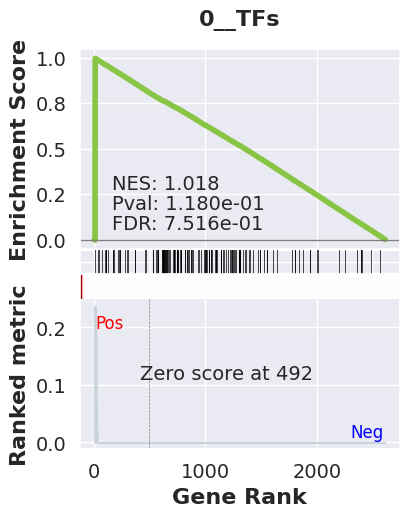

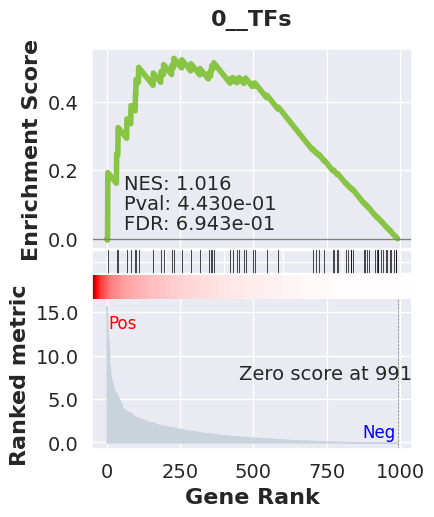

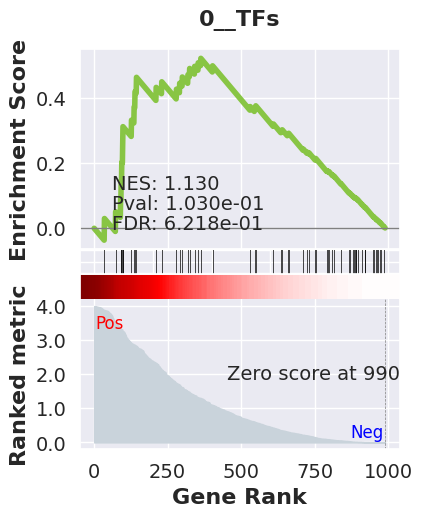

_________________________________________
TF specific enrichment


found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath


intersection of 1056 genes
intersection pct: 0.4035154757355751
precision:  0.0007555156889765451 
recall:  0.3545816733067729 
random precision: 0.0006670174487512689


  0%|                                                                              | 0/128 [00:00<?, ?it/s]

 48%|████████████████████████████████▉                                   | 62/128 [00:00<00:00, 613.21it/s]

 98%|█████████████████████████████████████████████████████████████████▍ | 125/128 [00:00<00:00, 622.17it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:857: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|███████████████████████████████████████████████████████████████████| 128/128 [00:00<00:00, 613.26it/s]

Average Precision (AP):  0.0009054023493249836
Area Under Precision-Recall Curve (AUPRC):  0.0008124073085834153
EPR: 0.0


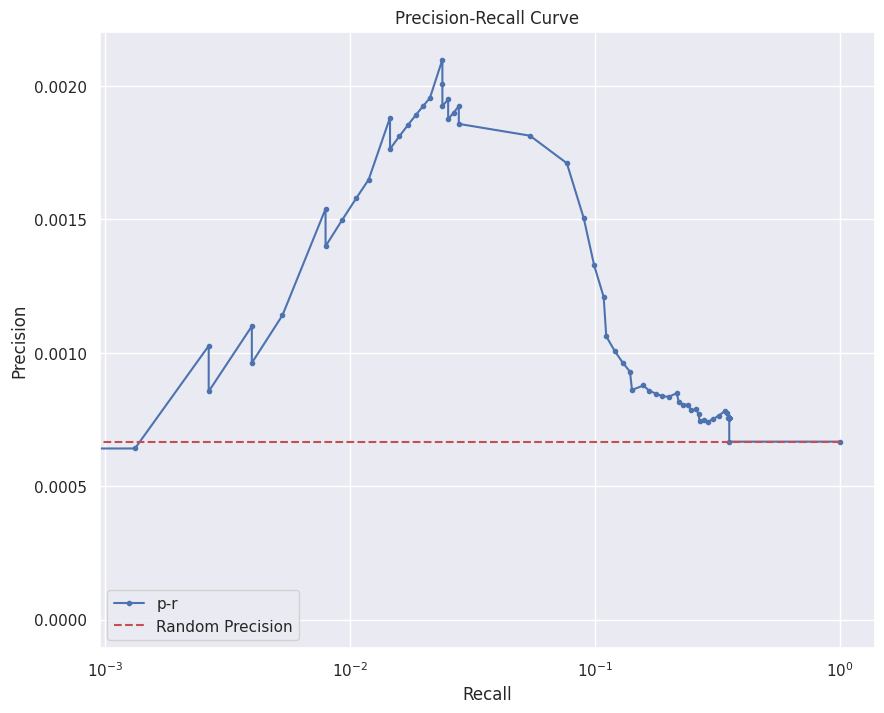

base enrichment


Top central genes: []


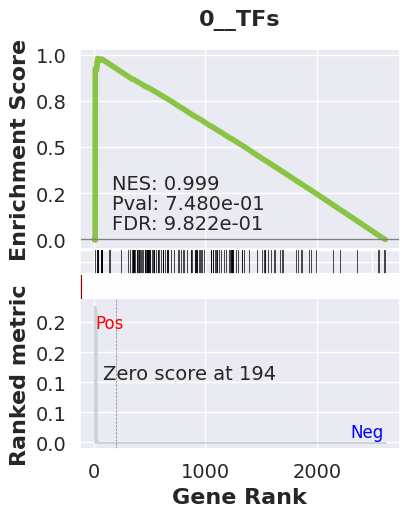

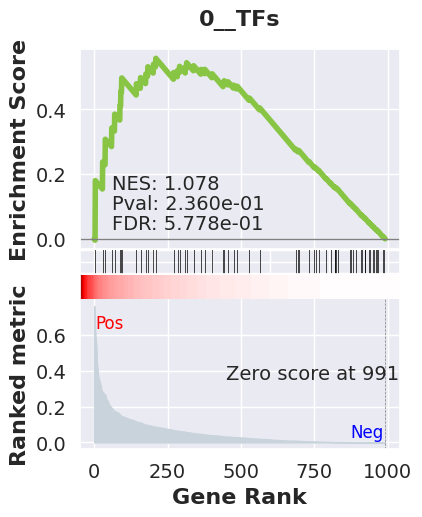

_________________________________________
TF specific enrichment


found some significant results for  66.66666666666667 % TFs

_________________________________________
loading GT,  omnipath


intersection of 1056 genes
intersection pct: 0.4035154757355751
precision:  0.005376763032806047 
recall:  0.18326693227091634 
random precision: 0.0006670174487512689


  0%|                                                                              | 0/128 [00:00<?, ?it/s]

 50%|██████████████████████████████████                                  | 64/128 [00:00<00:00, 635.02it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:857: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|███████████████████████████████████████████████████████████████████| 128/128 [00:00<00:00, 586.01it/s]

100%|███████████████████████████████████████████████████████████████████| 128/128 [00:00<00:00, 589.91it/s]

Average Precision (AP):  0.0024262226423799036
Area Under Precision-Recall Curve (AUPRC):  0.0019526636510102642
EPR: 12.122449637909066


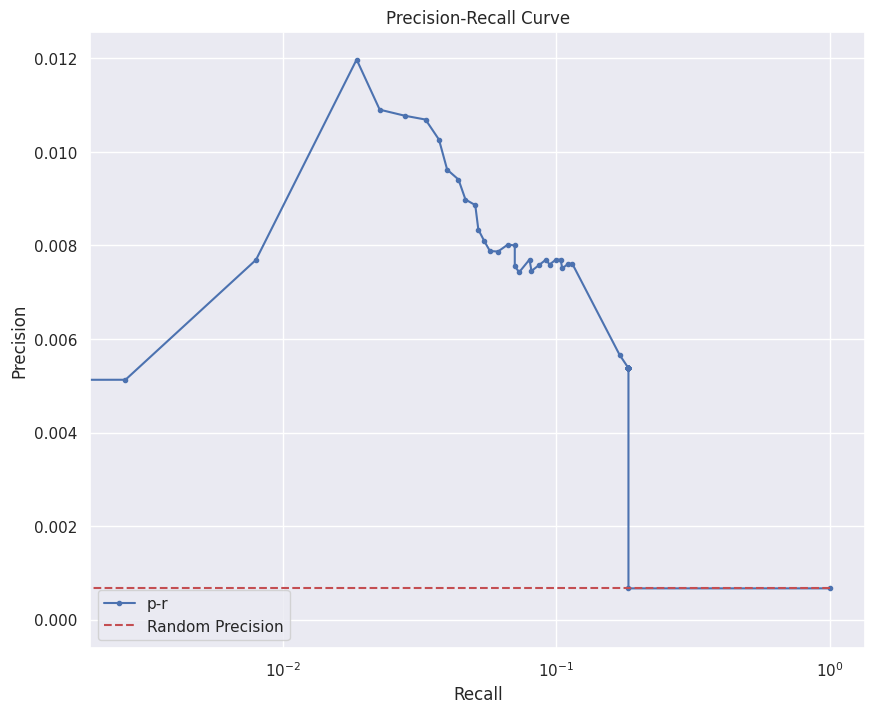

/tmp/ipykernel_2398049/468805686.py:16: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['ensembl_id'] = adata.var.index


Tokenizing /tmp/geneformer/test.h5ad


/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:473: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for i in adata.var["ensembl_id_collapsed"][coding_miRNA_loc]
/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:476: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coding_miRNA_ids = adata.var["ensembl_id_collapsed"][coding_miRNA_loc]


/tmp/geneformer/test.h5ad has no column attribute 'filter_pass'; tokenizing all cells.


Creating dataset.


/home/ml4ig1/miniconda3/envs/geneformer/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
[d3graph] WARNING> CLS token present in token dictionary, excluding from average.


[d3graph] WARNING> EOS token present in token dictionary, excluding from average.


  0%|          | 0/250 [00:00<?, ?it/s]

base enrichment


Top central genes: []


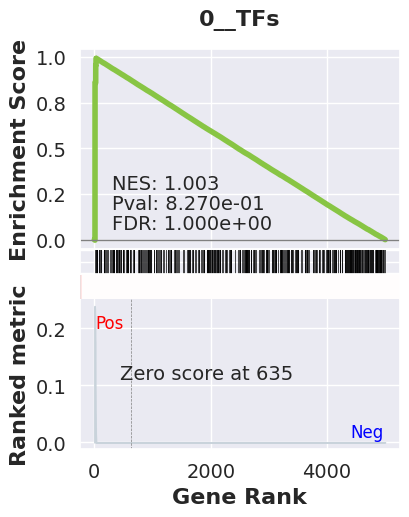

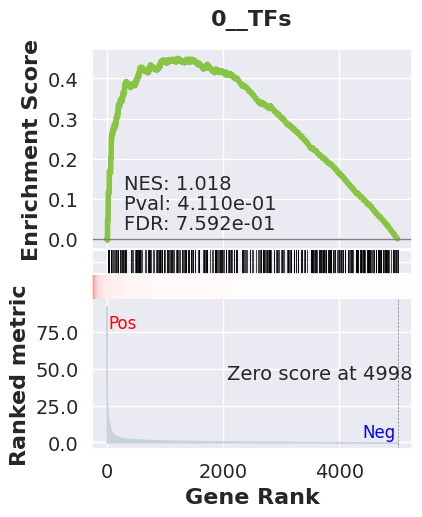

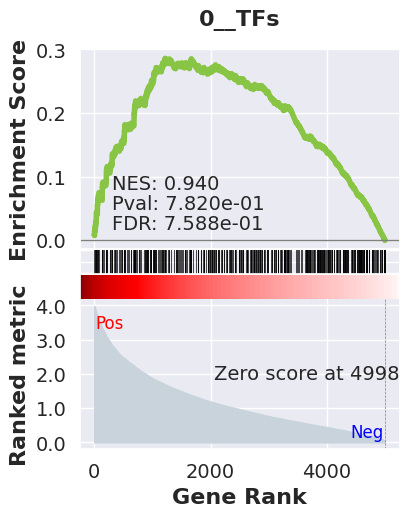

_________________________________________
TF specific enrichment


found some significant results for  17.24137931034483 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3634 genes
intersection pct: 0.7269453890778156
precision:  0.0013727051961657907 
recall:  0.9936172554198305 
random precision: 0.001376576029580251


  0%|                                                                              | 0/128 [00:00<?, ?it/s]

  4%|██▋                                                                   | 5/128 [00:00<00:02, 42.05it/s]

  8%|█████▍                                                               | 10/128 [00:00<00:02, 45.15it/s]

 12%|████████                                                             | 15/128 [00:00<00:02, 42.94it/s]

 16%|██████████▊                                                          | 20/128 [00:00<00:02, 45.07it/s]

 20%|█████████████▍                                                       | 25/128 [00:00<00:02, 43.21it/s]

 23%|████████████████▏                                                    | 30/128 [00:00<00:02, 43.84it/s]

 27%|██████████████████▊                                                  | 35/128 [00:00<00:02, 43.18it/s]

 31%|█████████████████████▌                                               | 40/128 [00:00<00:01, 44.75it/s]

 35%|████████████████████████▎                                            | 45/128 [00:01<00:01, 44.69it/s]

 39%|██████████████████████████▉                                          | 50/128 [00:01<00:01, 44.49it/s]

 43%|█████████████████████████████▋                                       | 55/128 [00:01<00:01, 45.28it/s]

 47%|████████████████████████████████▎                                    | 60/128 [00:01<00:01, 43.83it/s]

 51%|███████████████████████████████████                                  | 65/128 [00:01<00:01, 45.01it/s]

 55%|█████████████████████████████████████▋                               | 70/128 [00:01<00:01, 43.56it/s]

 59%|████████████████████████████████████████▍                            | 75/128 [00:01<00:01, 43.96it/s]

 62%|███████████████████████████████████████████▏                         | 80/128 [00:01<00:01, 43.43it/s]

 66%|█████████████████████████████████████████████▊                       | 85/128 [00:01<00:00, 44.76it/s]

 70%|████████████████████████████████████████████████▌                    | 90/128 [00:02<00:00, 43.84it/s]

 74%|███████████████████████████████████████████████████▏                 | 95/128 [00:02<00:00, 44.76it/s]

 78%|█████████████████████████████████████████████████████▏              | 100/128 [00:02<00:00, 44.72it/s]

 82%|███████████████████████████████████████████████████████▊            | 105/128 [00:02<00:00, 44.15it/s]

 86%|██████████████████████████████████████████████████████████▍         | 110/128 [00:02<00:00, 45.42it/s]

 90%|█████████████████████████████████████████████████████████████       | 115/128 [00:02<00:00, 44.08it/s]

 94%|███████████████████████████████████████████████████████████████▊    | 120/128 [00:02<00:00, 44.10it/s]

 98%|██████████████████████████████████████████████████████████████████▍ | 125/128 [00:02<00:00, 44.15it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:857: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|████████████████████████████████████████████████████████████████████| 128/128 [00:02<00:00, 44.33it/s]

Average Precision (AP):  0.0016713020672448414
Area Under Precision-Recall Curve (AUPRC):  0.0016706031836856983
EPR: 1.8026827100358513


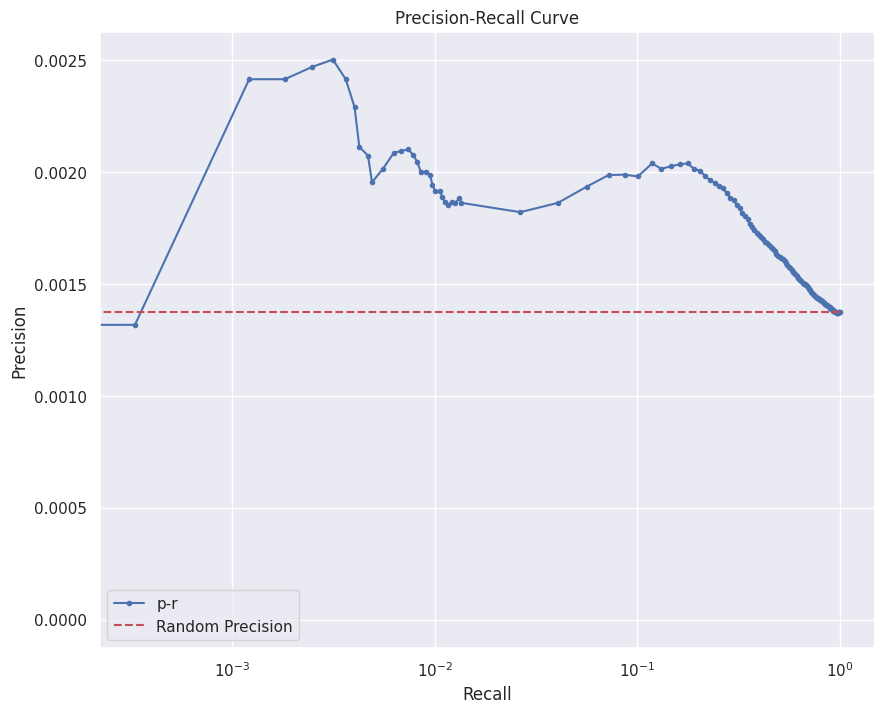

base enrichment


Top central genes: []


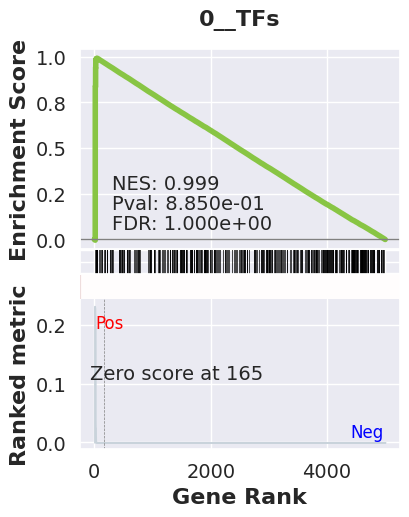

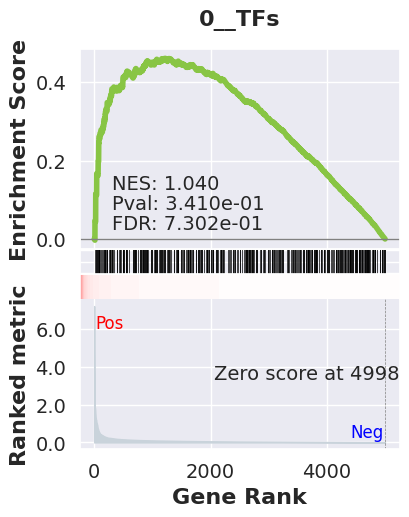

_________________________________________
TF specific enrichment


found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3634 genes
intersection pct: 0.7269453890778156
precision:  0.0060393640046097485 
recall:  0.42560801144492133 
random precision: 0.001376576029580251


  0%|                                                                              | 0/128 [00:00<?, ?it/s]

  4%|██▋                                                                   | 5/128 [00:00<00:02, 49.13it/s]

  8%|█████▍                                                               | 10/128 [00:00<00:02, 45.05it/s]

 12%|████████                                                             | 15/128 [00:00<00:02, 46.97it/s]

 16%|██████████▊                                                          | 20/128 [00:00<00:02, 44.28it/s]

 20%|█████████████▍                                                       | 25/128 [00:00<00:02, 46.09it/s]

 23%|████████████████▏                                                    | 30/128 [00:00<00:02, 45.43it/s]

 27%|██████████████████▊                                                  | 35/128 [00:00<00:02, 44.87it/s]

 31%|█████████████████████▌                                               | 40/128 [00:00<00:02, 43.96it/s]

 35%|████████████████████████▎                                            | 45/128 [00:01<00:01, 44.36it/s]

 39%|██████████████████████████▉                                          | 50/128 [00:01<00:01, 43.75it/s]

 43%|█████████████████████████████▋                                       | 55/128 [00:01<00:01, 42.07it/s]

 47%|████████████████████████████████▎                                    | 60/128 [00:01<00:01, 42.57it/s]

 51%|███████████████████████████████████                                  | 65/128 [00:01<00:01, 41.76it/s]

 55%|█████████████████████████████████████▋                               | 70/128 [00:01<00:01, 43.07it/s]

 59%|████████████████████████████████████████▍                            | 75/128 [00:01<00:01, 42.02it/s]

 62%|███████████████████████████████████████████▏                         | 80/128 [00:01<00:01, 42.62it/s]

 66%|█████████████████████████████████████████████▊                       | 85/128 [00:01<00:01, 42.70it/s]

 70%|████████████████████████████████████████████████▌                    | 90/128 [00:02<00:00, 44.12it/s]

 74%|███████████████████████████████████████████████████▏                 | 95/128 [00:02<00:00, 42.68it/s]

 78%|█████████████████████████████████████████████████████▏              | 100/128 [00:02<00:00, 43.73it/s]

 82%|███████████████████████████████████████████████████████▊            | 105/128 [00:02<00:00, 43.24it/s]

 86%|██████████████████████████████████████████████████████████▍         | 110/128 [00:02<00:00, 44.16it/s]

 90%|█████████████████████████████████████████████████████████████       | 115/128 [00:02<00:00, 45.34it/s]

 94%|███████████████████████████████████████████████████████████████▊    | 120/128 [00:02<00:00, 45.09it/s]

 98%|██████████████████████████████████████████████████████████████████▍ | 125/128 [00:02<00:00, 45.13it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:857: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|████████████████████████████████████████████████████████████████████| 128/128 [00:02<00:00, 43.98it/s]

Average Precision (AP):  0.0042618203764267235
Area Under Precision-Recall Curve (AUPRC):  0.0036697630908297477
EPR: 6.45040271048065


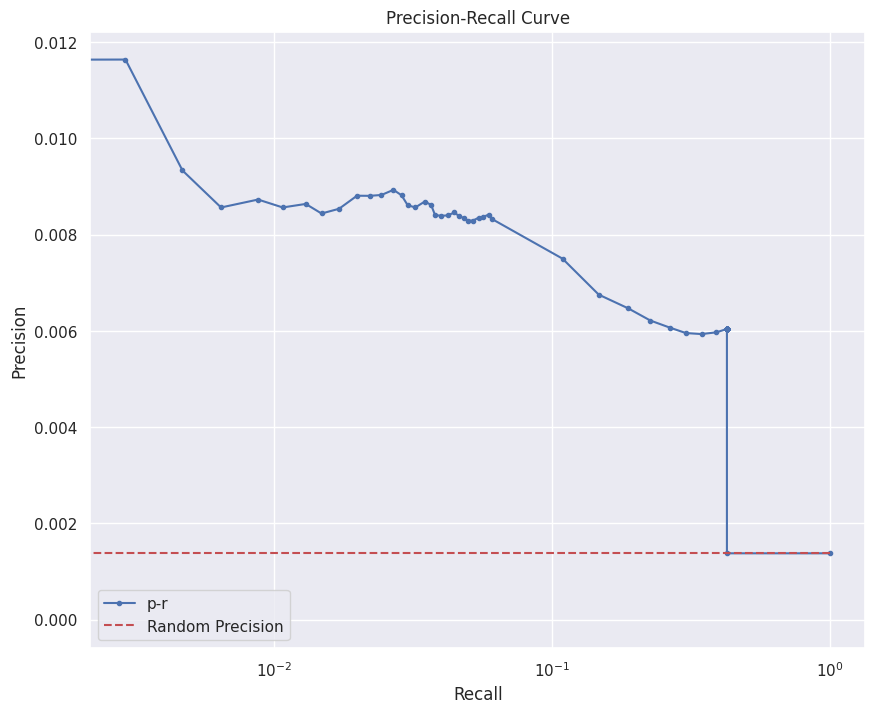

/tmp/ipykernel_2398049/468805686.py:16: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['ensembl_id'] = adata.var.index


Tokenizing /tmp/geneformer/test.h5ad


/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:473: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for i in adata.var["ensembl_id_collapsed"][coding_miRNA_loc]
/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:476: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coding_miRNA_ids = adata.var["ensembl_id_collapsed"][coding_miRNA_loc]


/tmp/geneformer/test.h5ad has no column attribute 'filter_pass'; tokenizing all cells.


Creating dataset.


/home/ml4ig1/miniconda3/envs/geneformer/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
[d3graph] WARNING> CLS token present in token dictionary, excluding from average.


[d3graph] WARNING> EOS token present in token dictionary, excluding from average.


  0%|          | 0/250 [00:00<?, ?it/s]

base enrichment


Top central genes: []


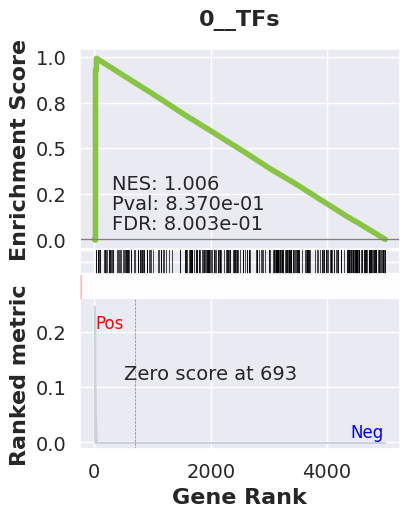

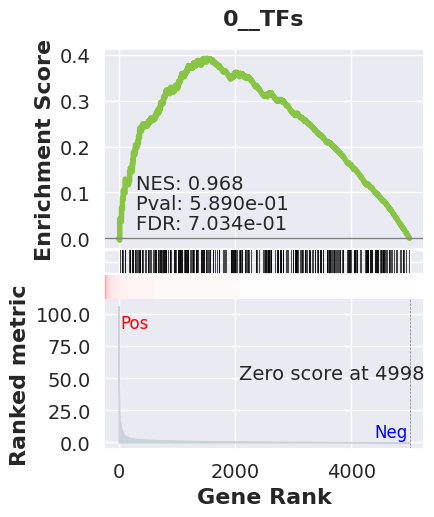

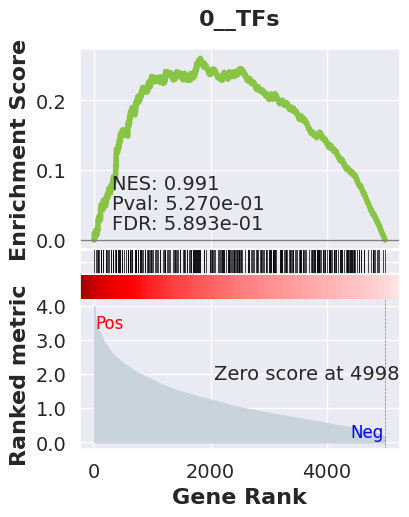

_________________________________________
TF specific enrichment


found some significant results for  21.428571428571427 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3599 genes
intersection pct: 0.7199439887977596
precision:  0.0008200835773341284 
recall:  1.0 
random precision: 0.0008202049825155249


  0%|                                                                              | 0/128 [00:00<?, ?it/s]

  5%|███▎                                                                  | 6/128 [00:00<00:02, 49.20it/s]

  9%|█████▉                                                               | 11/128 [00:00<00:02, 47.54it/s]

 12%|████████▋                                                            | 16/128 [00:00<00:02, 47.46it/s]

 16%|███████████▎                                                         | 21/128 [00:00<00:02, 48.13it/s]

 20%|██████████████                                                       | 26/128 [00:00<00:02, 46.06it/s]

 24%|████████████████▋                                                    | 31/128 [00:00<00:02, 44.17it/s]

 29%|███████████████████▉                                                 | 37/128 [00:00<00:01, 46.33it/s]

 33%|██████████████████████▋                                              | 42/128 [00:00<00:01, 45.26it/s]

 37%|█████████████████████████▎                                           | 47/128 [00:01<00:01, 46.16it/s]

 41%|████████████████████████████                                         | 52/128 [00:01<00:01, 45.56it/s]

 45%|██████████████████████████████▋                                      | 57/128 [00:01<00:01, 45.28it/s]

 48%|█████████████████████████████████▍                                   | 62/128 [00:01<00:01, 44.63it/s]

 52%|████████████████████████████████████                                 | 67/128 [00:01<00:01, 45.07it/s]

 57%|███████████████████████████████████████▎                             | 73/128 [00:01<00:01, 47.43it/s]

 61%|██████████████████████████████████████████                           | 78/128 [00:01<00:01, 47.13it/s]

 65%|████████████████████████████████████████████▋                        | 83/128 [00:01<00:00, 47.56it/s]

 70%|███████████████████████████████████████████████▉                     | 89/128 [00:01<00:00, 48.55it/s]

 73%|██████████████████████████████████████████████████▋                  | 94/128 [00:02<00:00, 48.27it/s]

 78%|█████████████████████████████████████████████████████▏              | 100/128 [00:02<00:00, 49.29it/s]

 82%|███████████████████████████████████████████████████████▊            | 105/128 [00:02<00:00, 40.77it/s]

 86%|██████████████████████████████████████████████████████████▍         | 110/128 [00:02<00:00, 36.33it/s]

 89%|████████████████████████████████████████████████████████████▌       | 114/128 [00:02<00:00, 33.85it/s]

 92%|██████████████████████████████████████████████████████████████▋     | 118/128 [00:02<00:00, 32.42it/s]

 95%|████████████████████████████████████████████████████████████████▊   | 122/128 [00:02<00:00, 31.98it/s]

 98%|██████████████████████████████████████████████████████████████████▉ | 126/128 [00:03<00:00, 30.93it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:857: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|████████████████████████████████████████████████████████████████████| 128/128 [00:03<00:00, 40.99it/s]

Average Precision (AP):  0.0009441789760102286
Area Under Precision-Recall Curve (AUPRC):  0.0009434231480794065
EPR: 1.378360281338002


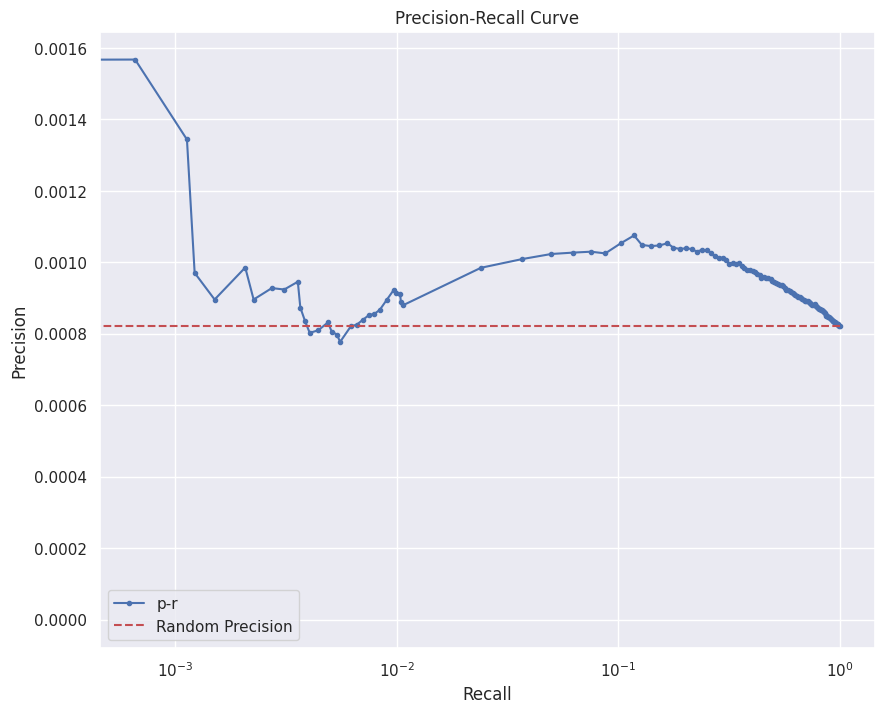

base enrichment


Top central genes: []


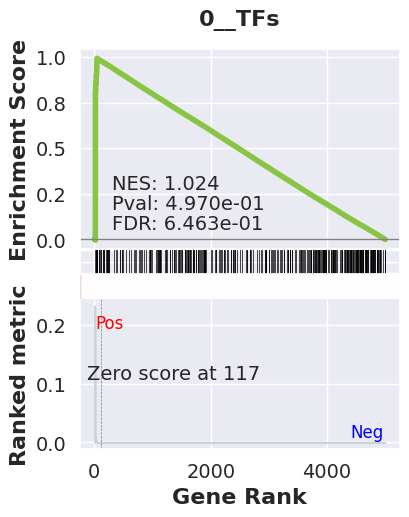

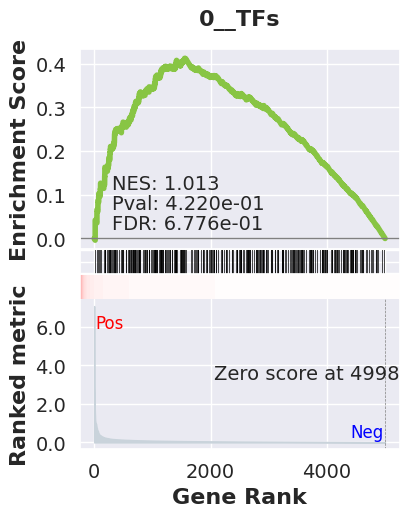

_________________________________________
TF specific enrichment


found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3599 genes
intersection pct: 0.7199439887977596
precision:  0.002895291554282775 
recall:  0.2766217870257038 
random precision: 0.0008202049825155249


  0%|                                                                              | 0/128 [00:00<?, ?it/s]

  5%|███▎                                                                  | 6/128 [00:00<00:02, 50.80it/s]

  9%|██████▍                                                              | 12/128 [00:00<00:02, 48.19it/s]

 13%|█████████▏                                                           | 17/128 [00:00<00:02, 47.24it/s]

 18%|████████████▍                                                        | 23/128 [00:00<00:02, 49.14it/s]

 22%|███████████████                                                      | 28/128 [00:00<00:02, 48.21it/s]

 27%|██████████████████▎                                                  | 34/128 [00:00<00:01, 49.17it/s]

 31%|█████████████████████▌                                               | 40/128 [00:00<00:01, 49.63it/s]

 35%|████████████████████████▎                                            | 45/128 [00:00<00:01, 48.31it/s]

 40%|███████████████████████████▍                                         | 51/128 [00:01<00:01, 49.67it/s]

 45%|██████████████████████████████▋                                      | 57/128 [00:01<00:01, 50.07it/s]

 49%|█████████████████████████████████▉                                   | 63/128 [00:01<00:01, 47.91it/s]

 54%|█████████████████████████████████████▏                               | 69/128 [00:01<00:01, 48.98it/s]

 59%|████████████████████████████████████████▍                            | 75/128 [00:01<00:01, 49.82it/s]

 62%|███████████████████████████████████████████▏                         | 80/128 [00:01<00:00, 48.05it/s]

 66%|█████████████████████████████████████████████▊                       | 85/128 [00:01<00:00, 48.41it/s]

 70%|████████████████████████████████████████████████▌                    | 90/128 [00:01<00:00, 47.68it/s]

 74%|███████████████████████████████████████████████████▏                 | 95/128 [00:01<00:00, 48.14it/s]

 78%|█████████████████████████████████████████████████████▏              | 100/128 [00:02<00:00, 47.30it/s]

 82%|███████████████████████████████████████████████████████▊            | 105/128 [00:02<00:00, 46.30it/s]

 86%|██████████████████████████████████████████████████████████▍         | 110/128 [00:02<00:00, 46.46it/s]

 90%|█████████████████████████████████████████████████████████████       | 115/128 [00:02<00:00, 46.81it/s]

 95%|████████████████████████████████████████████████████████████████▎   | 121/128 [00:02<00:00, 48.60it/s]

 98%|██████████████████████████████████████████████████████████████████▉ | 126/128 [00:02<00:00, 47.18it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:857: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|████████████████████████████████████████████████████████████████████| 128/128 [00:02<00:00, 48.10it/s]

Average Precision (AP):  0.0018368953751517914
Area Under Precision-Recall Curve (AUPRC):  0.0014471714881266538
EPR: 4.153861242937651


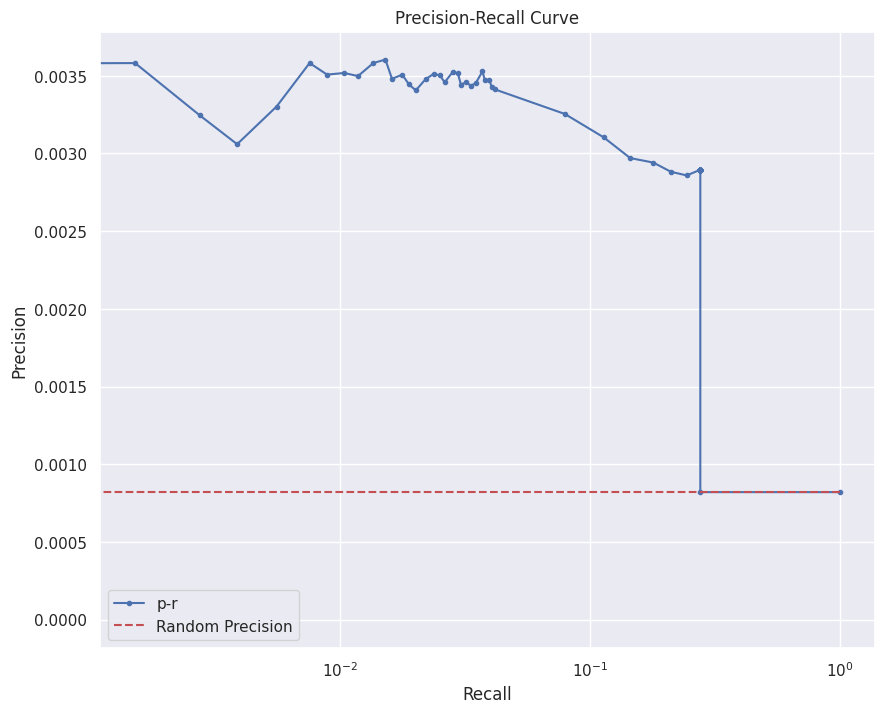

/tmp/ipykernel_2398049/468805686.py:16: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['ensembl_id'] = adata.var.index


Tokenizing /tmp/geneformer/test.h5ad


/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:473: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for i in adata.var["ensembl_id_collapsed"][coding_miRNA_loc]
/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:476: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coding_miRNA_ids = adata.var["ensembl_id_collapsed"][coding_miRNA_loc]


/tmp/geneformer/test.h5ad has no column attribute 'filter_pass'; tokenizing all cells.


Creating dataset.


/home/ml4ig1/miniconda3/envs/geneformer/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
[d3graph] WARNING> CLS token present in token dictionary, excluding from average.


[d3graph] WARNING> EOS token present in token dictionary, excluding from average.


  0%|          | 0/250 [00:00<?, ?it/s]

base enrichment


Top central genes: []


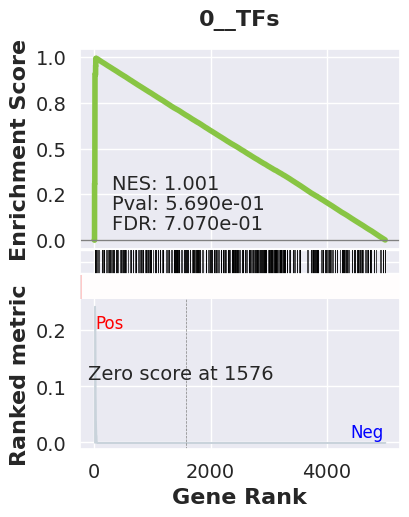

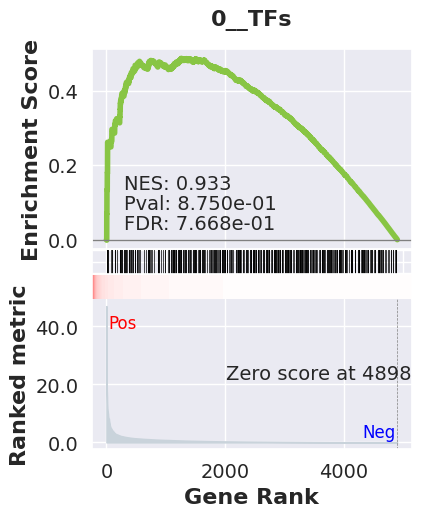

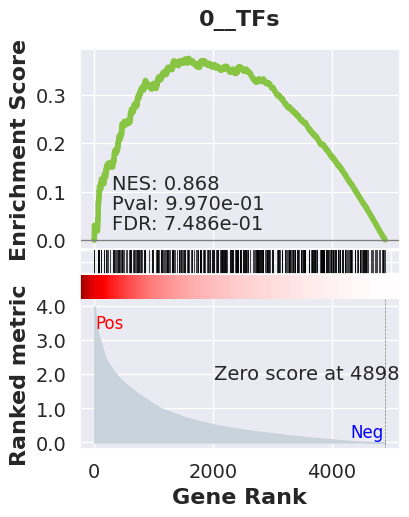

_________________________________________
TF specific enrichment


found some significant results for  6.666666666666667 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3357 genes
intersection pct: 0.6714
precision:  0.0007577811247607075 
recall:  0.8372846073782815 
random precision: 0.0007675243553842805


  0%|                                                                              | 0/128 [00:00<?, ?it/s]

  4%|██▋                                                                   | 5/128 [00:00<00:02, 49.43it/s]

  9%|█████▉                                                               | 11/128 [00:00<00:02, 54.56it/s]

 13%|█████████▏                                                           | 17/128 [00:00<00:02, 54.20it/s]

 19%|████████████▉                                                        | 24/128 [00:00<00:01, 57.73it/s]

 23%|████████████████▏                                                    | 30/128 [00:00<00:01, 56.67it/s]

 28%|███████████████████▍                                                 | 36/128 [00:00<00:01, 56.47it/s]

 34%|███████████████████████▏                                             | 43/128 [00:00<00:01, 57.83it/s]

 38%|██████████████████████████▍                                          | 49/128 [00:00<00:01, 56.42it/s]

 44%|██████████████████████████████▏                                      | 56/128 [00:00<00:01, 58.46it/s]

 48%|█████████████████████████████████▍                                   | 62/128 [00:01<00:01, 56.24it/s]

 53%|████████████████████████████████████▋                                | 68/128 [00:01<00:01, 57.07it/s]

 58%|███████████████████████████████████████▉                             | 74/128 [00:01<00:00, 56.13it/s]

 63%|███████████████████████████████████████████▋                         | 81/128 [00:01<00:00, 58.01it/s]

 68%|██████████████████████████████████████████████▉                      | 87/128 [00:01<00:00, 57.96it/s]

 73%|██████████████████████████████████████████████████▏                  | 93/128 [00:01<00:00, 56.83it/s]

 78%|█████████████████████████████████████████████████████▏              | 100/128 [00:01<00:00, 58.11it/s]

 83%|████████████████████████████████████████████████████████▎           | 106/128 [00:01<00:00, 56.62it/s]

 88%|████████████████████████████████████████████████████████████        | 113/128 [00:01<00:00, 58.59it/s]

 93%|███████████████████████████████████████████████████████████████▏    | 119/128 [00:02<00:00, 56.58it/s]

 98%|██████████████████████████████████████████████████████████████████▍ | 125/128 [00:02<00:00, 56.87it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:857: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|████████████████████████████████████████████████████████████████████| 128/128 [00:02<00:00, 56.72it/s]

Average Precision (AP):  0.0009588486344448015
Area Under Precision-Recall Curve (AUPRC):  0.0009568286865983888
EPR: 3.022854820983918


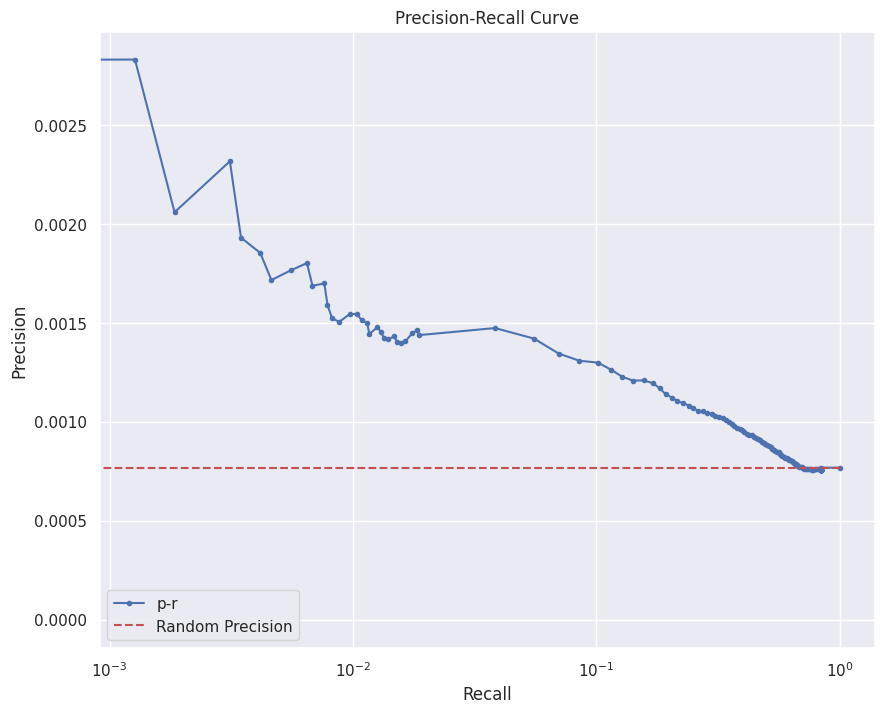

base enrichment


Top central genes: []


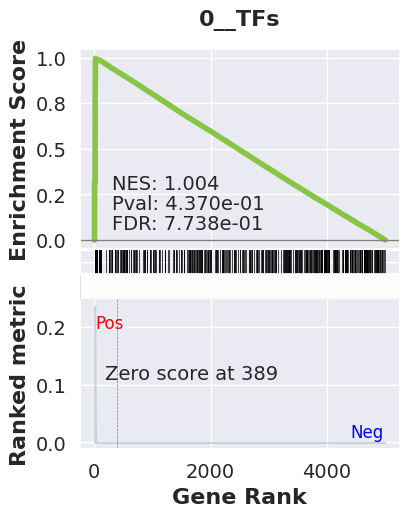

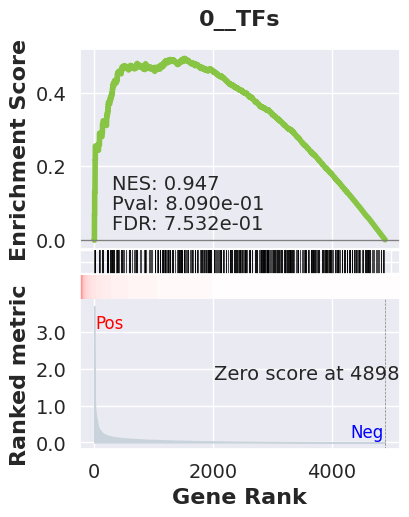

_________________________________________
TF specific enrichment


found some significant results for  6.666666666666667 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3357 genes
intersection pct: 0.6714
precision:  0.002260257813084058 
recall:  0.26922632126749163 
random precision: 0.0007675243553842805


  0%|                                                                              | 0/128 [00:00<?, ?it/s]

  5%|███▊                                                                  | 7/128 [00:00<00:01, 61.16it/s]

 11%|███████▌                                                             | 14/128 [00:00<00:01, 59.57it/s]

 16%|██████████▊                                                          | 20/128 [00:00<00:01, 57.29it/s]

 21%|██████████████▌                                                      | 27/128 [00:00<00:01, 59.05it/s]

 26%|█████████████████▊                                                   | 33/128 [00:00<00:01, 56.29it/s]

 31%|█████████████████████▌                                               | 40/128 [00:00<00:01, 58.08it/s]

 36%|████████████████████████▊                                            | 46/128 [00:00<00:01, 56.34it/s]

 41%|████████████████████████████                                         | 52/128 [00:00<00:01, 57.01it/s]

 45%|███████████████████████████████▎                                     | 58/128 [00:01<00:01, 55.76it/s]

 51%|███████████████████████████████████                                  | 65/128 [00:01<00:01, 57.77it/s]

 55%|██████████████████████████████████████▎                              | 71/128 [00:01<00:00, 57.90it/s]

 60%|█████████████████████████████████████████▌                           | 77/128 [00:01<00:00, 56.63it/s]

 65%|████████████████████████████████████████████▋                        | 83/128 [00:01<00:00, 57.36it/s]

 70%|███████████████████████████████████████████████▉                     | 89/128 [00:01<00:00, 55.05it/s]

 74%|███████████████████████████████████████████████████▏                 | 95/128 [00:01<00:00, 56.20it/s]

 79%|█████████████████████████████████████████████████████▋              | 101/128 [00:01<00:00, 55.36it/s]

 84%|████████████████████████████████████████████████████████▊           | 107/128 [00:01<00:00, 55.53it/s]

 88%|████████████████████████████████████████████████████████████        | 113/128 [00:02<00:00, 54.25it/s]

 93%|███████████████████████████████████████████████████████████████▏    | 119/128 [00:02<00:00, 55.64it/s]

 98%|██████████████████████████████████████████████████████████████████▍ | 125/128 [00:02<00:00, 56.71it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:857: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|████████████████████████████████████████████████████████████████████| 128/128 [00:02<00:00, 56.38it/s]

Average Precision (AP):  0.0013505236062822026
Area Under Precision-Recall Curve (AUPRC):  0.0011358283815193267
EPR: 3.1747338010293427


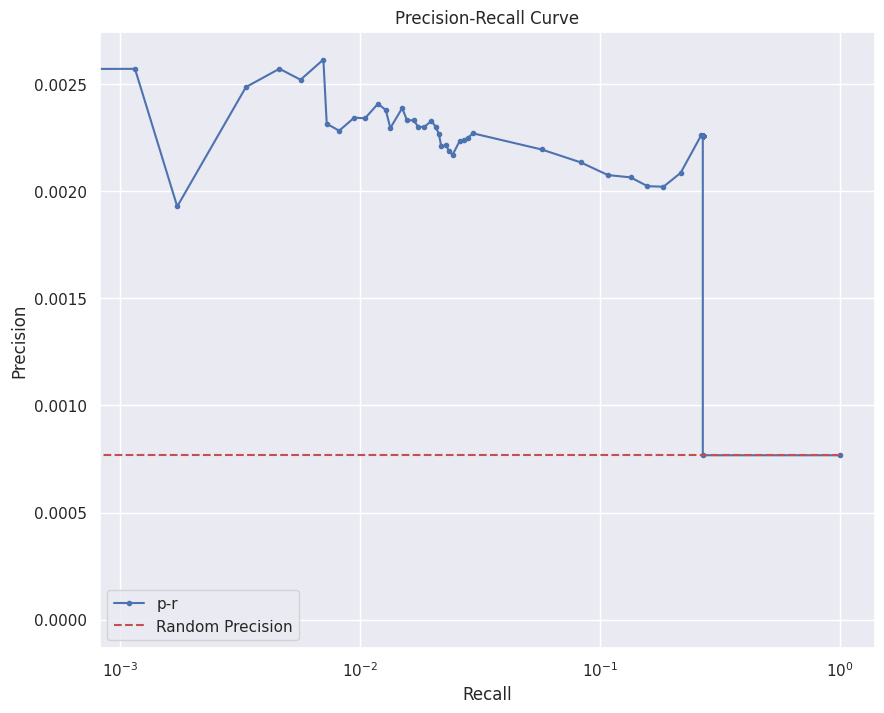

/tmp/ipykernel_2398049/468805686.py:16: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['ensembl_id'] = adata.var.index


Tokenizing /tmp/geneformer/test.h5ad


/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:473: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for i in adata.var["ensembl_id_collapsed"][coding_miRNA_loc]
/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:476: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coding_miRNA_ids = adata.var["ensembl_id_collapsed"][coding_miRNA_loc]


/tmp/geneformer/test.h5ad has no column attribute 'filter_pass'; tokenizing all cells.


Creating dataset.


/home/ml4ig1/miniconda3/envs/geneformer/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
[d3graph] WARNING> CLS token present in token dictionary, excluding from average.


[d3graph] WARNING> EOS token present in token dictionary, excluding from average.


  0%|          | 0/250 [00:00<?, ?it/s]

base enrichment


Top central genes: []


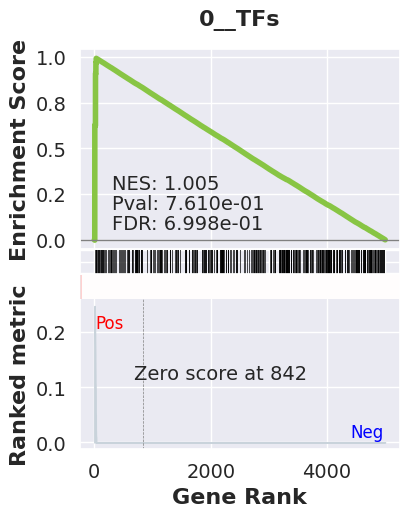

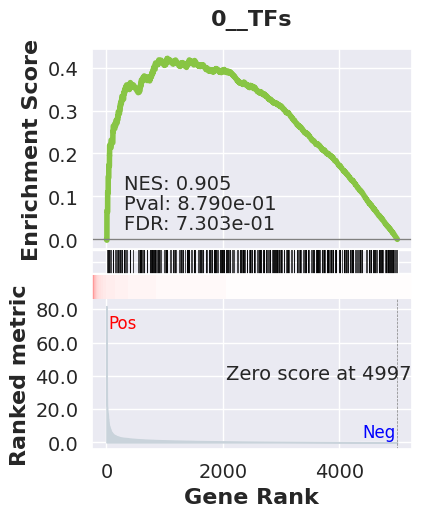

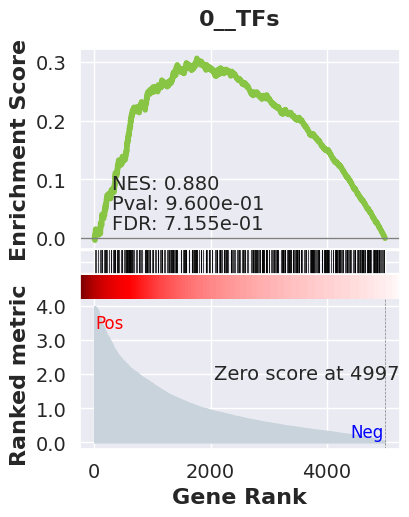

_________________________________________
TF specific enrichment


found some significant results for  7.142857142857143 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3521 genes
intersection pct: 0.7043408681736347
precision:  0.0006749371600419643 
recall:  0.9962802975761939 
random precision: 0.0006724264800805557


  0%|                                                                              | 0/128 [00:00<?, ?it/s]

  5%|███▎                                                                  | 6/128 [00:00<00:02, 51.73it/s]

  9%|██████▍                                                              | 12/128 [00:00<00:02, 52.92it/s]

 14%|█████████▋                                                           | 18/128 [00:00<00:02, 50.68it/s]

 19%|████████████▉                                                        | 24/128 [00:00<00:01, 52.31it/s]

 23%|████████████████▏                                                    | 30/128 [00:00<00:01, 52.67it/s]

 28%|███████████████████▍                                                 | 36/128 [00:00<00:01, 50.91it/s]

 33%|██████████████████████▋                                              | 42/128 [00:00<00:01, 51.78it/s]

 38%|█████████████████████████▉                                           | 48/128 [00:00<00:01, 53.29it/s]

 42%|█████████████████████████████                                        | 54/128 [00:01<00:01, 51.20it/s]

 47%|████████████████████████████████▎                                    | 60/128 [00:01<00:01, 52.20it/s]

 52%|███████████████████████████████████▌                                 | 66/128 [00:01<00:01, 50.79it/s]

 56%|██████████████████████████████████████▊                              | 72/128 [00:01<00:01, 50.21it/s]

 61%|██████████████████████████████████████████                           | 78/128 [00:01<00:00, 50.42it/s]

 66%|█████████████████████████████████████████████▎                       | 84/128 [00:01<00:00, 52.11it/s]

 70%|████████████████████████████████████████████████▌                    | 90/128 [00:01<00:00, 52.04it/s]

 75%|███████████████████████████████████████████████████▊                 | 96/128 [00:01<00:00, 51.34it/s]

 80%|██████████████████████████████████████████████████████▏             | 102/128 [00:01<00:00, 52.82it/s]

 84%|█████████████████████████████████████████████████████████▍          | 108/128 [00:02<00:00, 51.57it/s]

 89%|████████████████████████████████████████████████████████████▌       | 114/128 [00:02<00:00, 52.33it/s]

 94%|███████████████████████████████████████████████████████████████▊    | 120/128 [00:02<00:00, 52.10it/s]

 98%|██████████████████████████████████████████████████████████████████▉ | 126/128 [00:02<00:00, 50.43it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:857: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|████████████████████████████████████████████████████████████████████| 128/128 [00:02<00:00, 51.57it/s]

Average Precision (AP):  0.0008752747202789356
Area Under Precision-Recall Curve (AUPRC):  0.0008742988068420644
EPR: 1.607306030354679


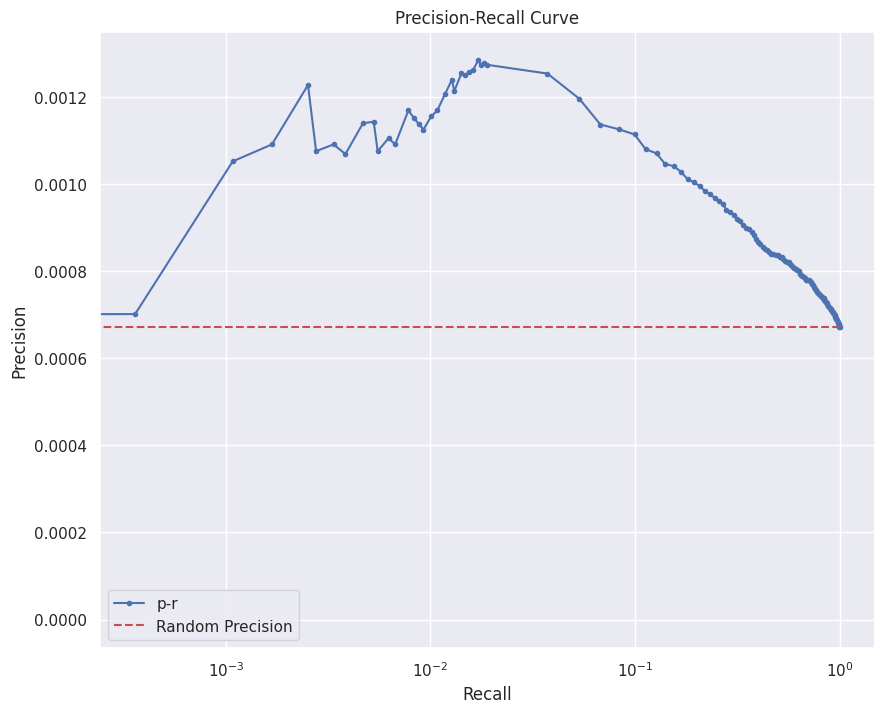

base enrichment


Top central genes: []


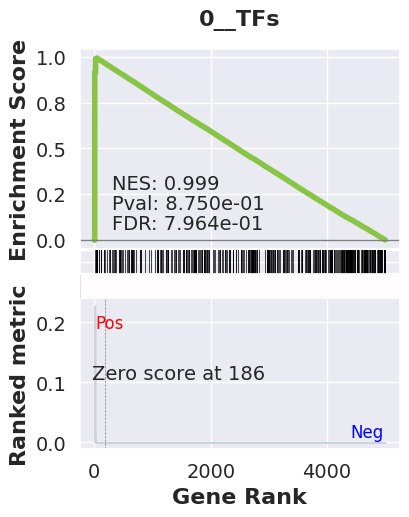

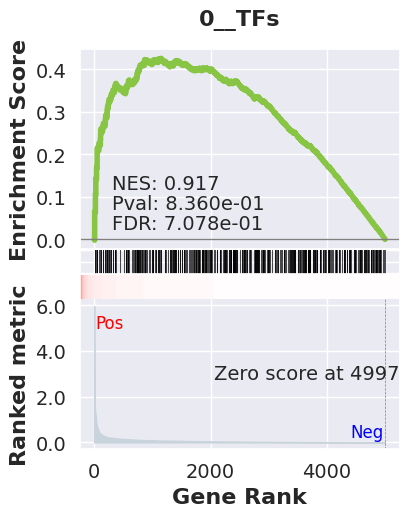

_________________________________________
TF specific enrichment


found some significant results for  17.857142857142858 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3521 genes
intersection pct: 0.7043408681736347
precision:  0.0016887643888096556 
recall:  0.2377009839212863 
random precision: 0.0006724264800805557


  0%|                                                                              | 0/128 [00:00<?, ?it/s]

  5%|███▎                                                                  | 6/128 [00:00<00:02, 55.13it/s]

  9%|██████▍                                                              | 12/128 [00:00<00:02, 53.09it/s]

 14%|█████████▋                                                           | 18/128 [00:00<00:02, 52.31it/s]

 19%|████████████▉                                                        | 24/128 [00:00<00:01, 52.37it/s]

 23%|████████████████▏                                                    | 30/128 [00:00<00:01, 51.59it/s]

 28%|███████████████████▍                                                 | 36/128 [00:00<00:01, 52.74it/s]

 33%|██████████████████████▋                                              | 42/128 [00:00<00:01, 52.37it/s]

 38%|█████████████████████████▉                                           | 48/128 [00:00<00:01, 53.33it/s]

 42%|█████████████████████████████                                        | 54/128 [00:01<00:01, 51.49it/s]

 47%|████████████████████████████████▎                                    | 60/128 [00:01<00:01, 52.67it/s]

 52%|███████████████████████████████████▌                                 | 66/128 [00:01<00:01, 53.21it/s]

 56%|██████████████████████████████████████▊                              | 72/128 [00:01<00:01, 51.29it/s]

 61%|██████████████████████████████████████████                           | 78/128 [00:01<00:00, 52.36it/s]

 66%|█████████████████████████████████████████████▎                       | 84/128 [00:01<00:00, 50.94it/s]

 70%|████████████████████████████████████████████████▌                    | 90/128 [00:01<00:00, 52.30it/s]

 75%|███████████████████████████████████████████████████▊                 | 96/128 [00:01<00:00, 51.12it/s]

 80%|██████████████████████████████████████████████████████▏             | 102/128 [00:01<00:00, 51.02it/s]

 84%|█████████████████████████████████████████████████████████▍          | 108/128 [00:02<00:00, 50.31it/s]

 89%|████████████████████████████████████████████████████████████▌       | 114/128 [00:02<00:00, 51.85it/s]

 94%|███████████████████████████████████████████████████████████████▊    | 120/128 [00:02<00:00, 51.61it/s]

 98%|██████████████████████████████████████████████████████████████████▉ | 126/128 [00:02<00:00, 51.64it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:857: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|████████████████████████████████████████████████████████████████████| 128/128 [00:02<00:00, 51.93it/s]

Average Precision (AP):  0.0012130486117947546
Area Under Precision-Recall Curve (AUPRC):  0.0010019135161114996
EPR: 4.842844493692159


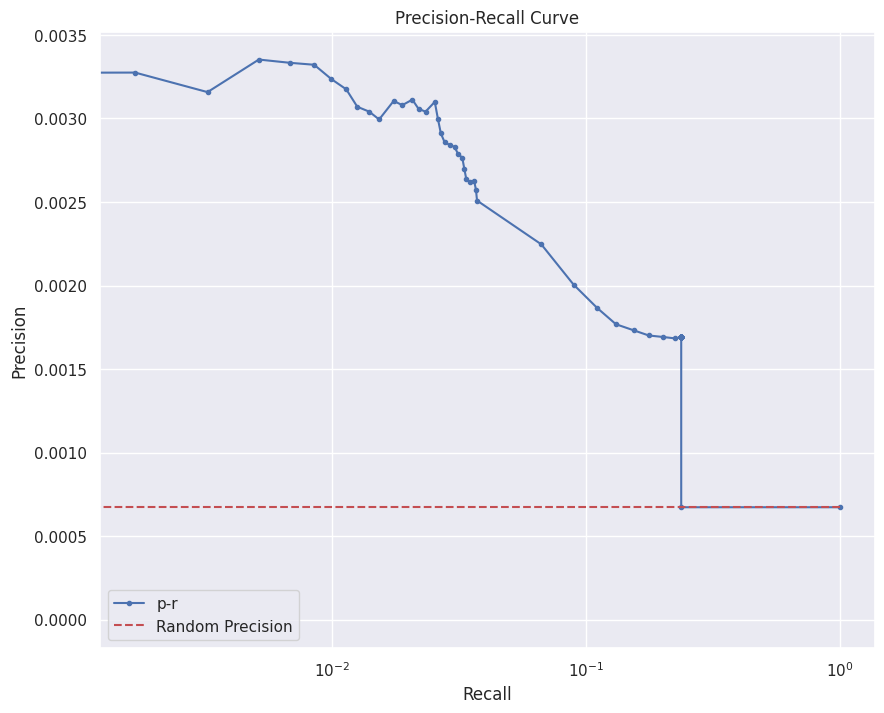

/tmp/ipykernel_2398049/468805686.py:16: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['ensembl_id'] = adata.var.index


Tokenizing /tmp/geneformer/test.h5ad


/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:473: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for i in adata.var["ensembl_id_collapsed"][coding_miRNA_loc]
/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:476: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coding_miRNA_ids = adata.var["ensembl_id_collapsed"][coding_miRNA_loc]


/tmp/geneformer/test.h5ad has no column attribute 'filter_pass'; tokenizing all cells.


Creating dataset.


/home/ml4ig1/miniconda3/envs/geneformer/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(


[d3graph] WARNING> CLS token present in token dictionary, excluding from average.


[d3graph] WARNING> EOS token present in token dictionary, excluding from average.


  0%|          | 0/250 [00:00<?, ?it/s]

base enrichment


Top central genes: []


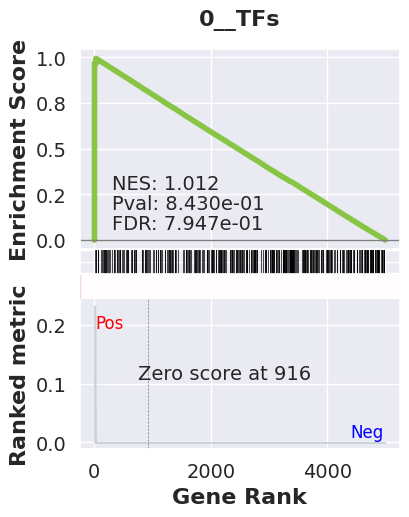

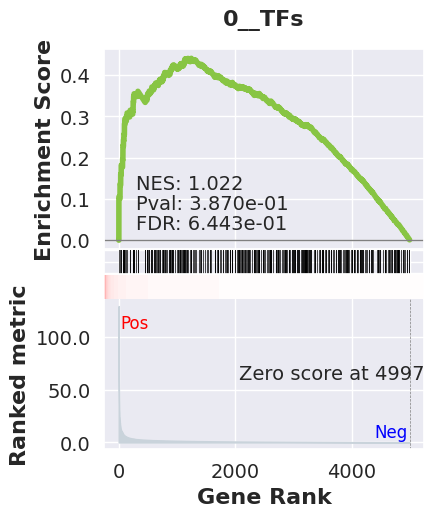

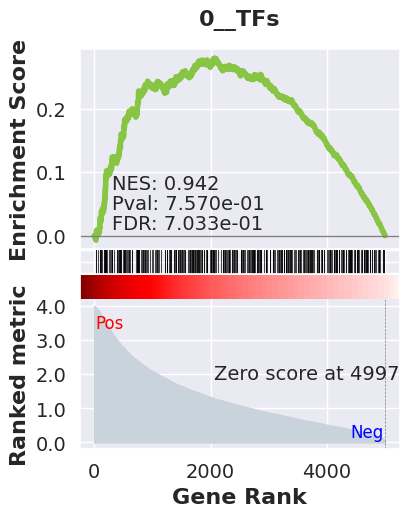

_________________________________________
TF specific enrichment


found some significant results for  15.151515151515152 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3521 genes
intersection pct: 0.7044817927170869
precision:  0.0007681197834118582 
recall:  0.9994747347410442 
random precision: 0.0007680378766362862


  0%|                                                                              | 0/128 [00:00<?, ?it/s]

  4%|██▋                                                                   | 5/128 [00:00<00:02, 45.96it/s]

  9%|█████▉                                                               | 11/128 [00:00<00:02, 50.89it/s]

 13%|█████████▏                                                           | 17/128 [00:00<00:02, 50.22it/s]

 18%|████████████▍                                                        | 23/128 [00:00<00:02, 51.68it/s]

 23%|███████████████▋                                                     | 29/128 [00:00<00:01, 51.31it/s]

 27%|██████████████████▊                                                  | 35/128 [00:00<00:01, 50.27it/s]

 32%|██████████████████████                                               | 41/128 [00:00<00:01, 49.45it/s]

 37%|█████████████████████████▎                                           | 47/128 [00:00<00:01, 51.26it/s]

 41%|████████████████████████████▌                                        | 53/128 [00:01<00:01, 51.95it/s]

 46%|███████████████████████████████▊                                     | 59/128 [00:01<00:01, 50.31it/s]

 51%|███████████████████████████████████                                  | 65/128 [00:01<00:01, 51.79it/s]

 55%|██████████████████████████████████████▎                              | 71/128 [00:01<00:01, 50.57it/s]

 60%|█████████████████████████████████████████▌                           | 77/128 [00:01<00:00, 52.04it/s]

 65%|████████████████████████████████████████████▋                        | 83/128 [00:01<00:00, 50.75it/s]

 70%|███████████████████████████████████████████████▉                     | 89/128 [00:01<00:00, 50.90it/s]

 74%|███████████████████████████████████████████████████▏                 | 95/128 [00:01<00:00, 50.79it/s]

 79%|█████████████████████████████████████████████████████▋              | 101/128 [00:01<00:00, 52.17it/s]

 84%|████████████████████████████████████████████████████████▊           | 107/128 [00:02<00:00, 50.81it/s]

 88%|████████████████████████████████████████████████████████████        | 113/128 [00:02<00:00, 52.00it/s]

 93%|███████████████████████████████████████████████████████████████▏    | 119/128 [00:02<00:00, 50.82it/s]

 98%|██████████████████████████████████████████████████████████████████▍ | 125/128 [00:02<00:00, 51.14it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:857: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|████████████████████████████████████████████████████████████████████| 128/128 [00:02<00:00, 51.04it/s]

Average Precision (AP):  0.0009588489713997642
Area Under Precision-Recall Curve (AUPRC):  0.0009582188877835366
EPR: 2.055038661286688


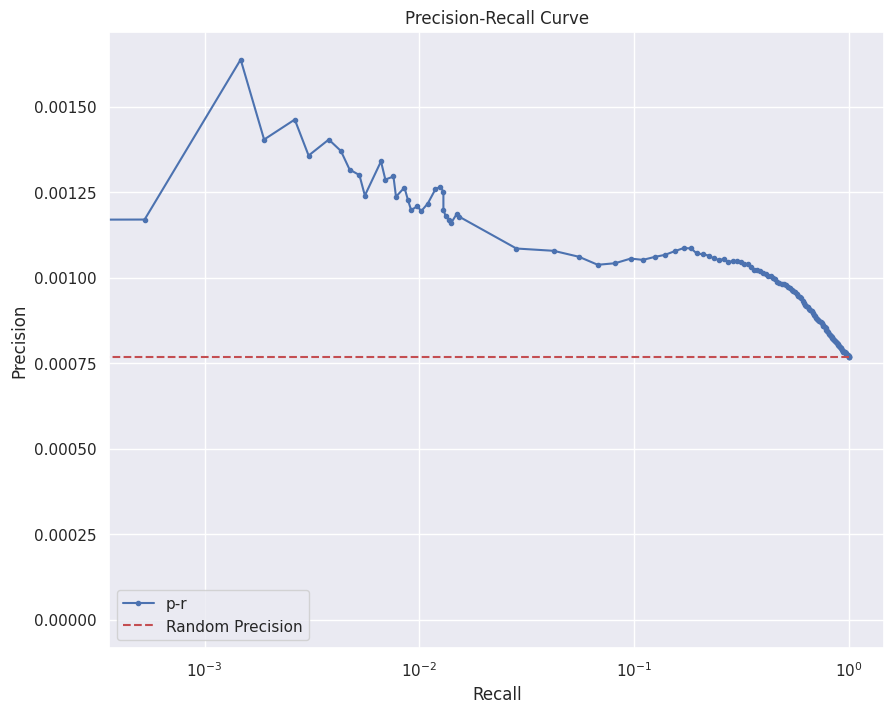

base enrichment


Top central genes: []


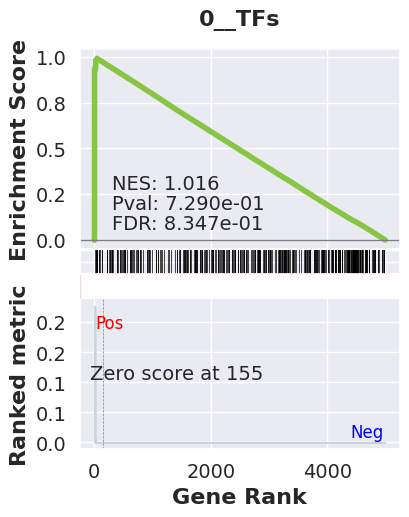

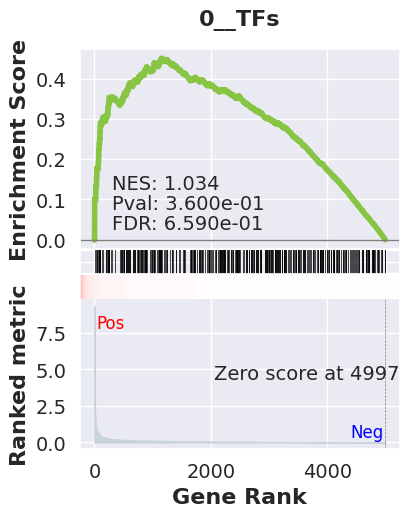

_________________________________________
TF specific enrichment


found some significant results for  18.181818181818183 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3521 genes
intersection pct: 0.7044817927170869
precision:  0.0028302494637023113 
recall:  0.3137934657001786 
random precision: 0.0007680378766362862


  0%|                                                                              | 0/128 [00:00<?, ?it/s]

  5%|███▎                                                                  | 6/128 [00:00<00:02, 55.47it/s]

  9%|██████▍                                                              | 12/128 [00:00<00:02, 50.80it/s]

 14%|█████████▋                                                           | 18/128 [00:00<00:02, 52.68it/s]

 19%|████████████▉                                                        | 24/128 [00:00<00:02, 50.24it/s]

 23%|████████████████▏                                                    | 30/128 [00:00<00:01, 51.44it/s]

 28%|███████████████████▍                                                 | 36/128 [00:00<00:01, 50.95it/s]

 33%|██████████████████████▋                                              | 42/128 [00:00<00:01, 51.10it/s]

 38%|█████████████████████████▉                                           | 48/128 [00:00<00:01, 49.42it/s]

 42%|█████████████████████████████                                        | 54/128 [00:01<00:01, 49.96it/s]

 47%|████████████████████████████████▎                                    | 60/128 [00:01<00:01, 50.25it/s]

 52%|███████████████████████████████████▌                                 | 66/128 [00:01<00:01, 49.61it/s]

 56%|██████████████████████████████████████▊                              | 72/128 [00:01<00:01, 50.00it/s]

 61%|██████████████████████████████████████████                           | 78/128 [00:01<00:01, 49.21it/s]

 66%|█████████████████████████████████████████████▎                       | 84/128 [00:01<00:00, 49.98it/s]

 70%|████████████████████████████████████████████████▌                    | 90/128 [00:01<00:00, 49.16it/s]

 74%|███████████████████████████████████████████████████▏                 | 95/128 [00:01<00:00, 47.99it/s]

 79%|█████████████████████████████████████████████████████▋              | 101/128 [00:02<00:00, 49.34it/s]

 84%|████████████████████████████████████████████████████████▊           | 107/128 [00:02<00:00, 51.37it/s]

 88%|████████████████████████████████████████████████████████████        | 113/128 [00:02<00:00, 49.86it/s]

 93%|███████████████████████████████████████████████████████████████▏    | 119/128 [00:02<00:00, 51.59it/s]

 98%|██████████████████████████████████████████████████████████████████▍ | 125/128 [00:02<00:00, 50.38it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:857: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|████████████████████████████████████████████████████████████████████| 128/128 [00:02<00:00, 50.34it/s]

Average Precision (AP):  0.0019091974205624948
Area Under Precision-Recall Curve (AUPRC):  0.0015846839350432973
EPR: 8.018571582216575


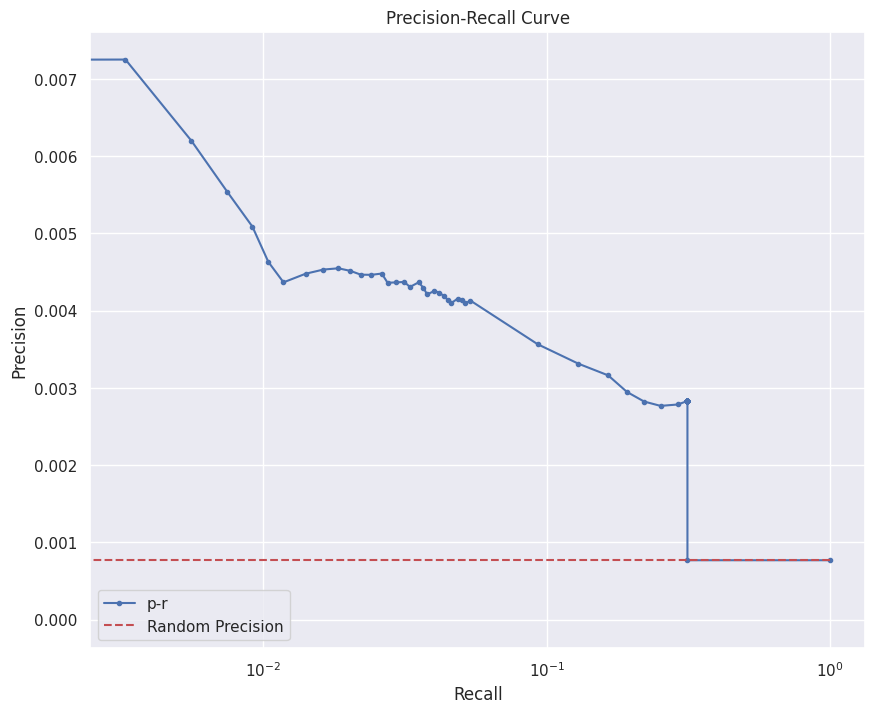

/tmp/ipykernel_2398049/468805686.py:16: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['ensembl_id'] = adata.var.index


Tokenizing /tmp/geneformer/test.h5ad


/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:473: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for i in adata.var["ensembl_id_collapsed"][coding_miRNA_loc]
/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:476: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coding_miRNA_ids = adata.var["ensembl_id_collapsed"][coding_miRNA_loc]


/tmp/geneformer/test.h5ad has no column attribute 'filter_pass'; tokenizing all cells.


Creating dataset.


/home/ml4ig1/miniconda3/envs/geneformer/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
[d3graph] WARNING> CLS token present in token dictionary, excluding from average.


[d3graph] WARNING> EOS token present in token dictionary, excluding from average.


  0%|          | 0/250 [00:00<?, ?it/s]

base enrichment


Top central genes: []


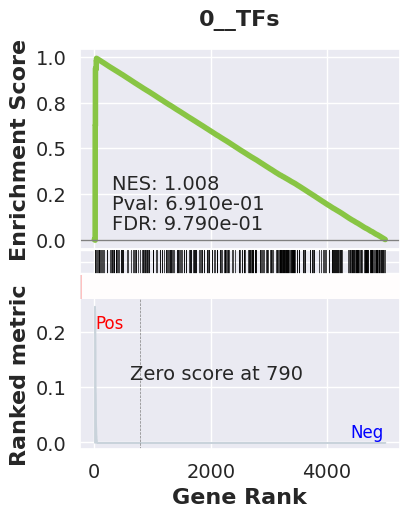

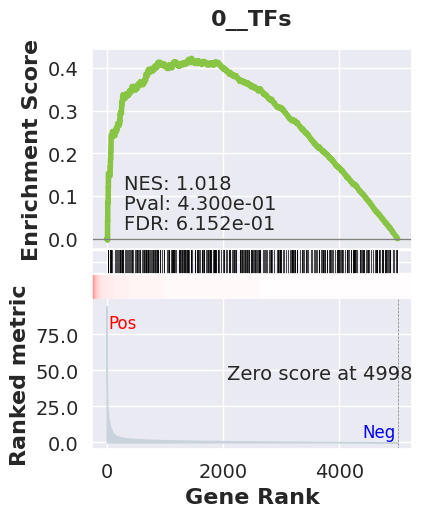

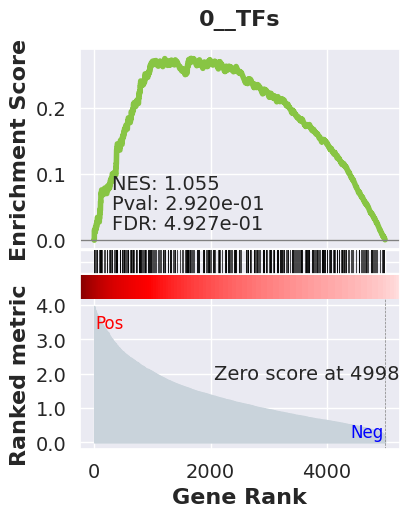

_________________________________________
TF specific enrichment


found some significant results for  23.076923076923077 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3550 genes
intersection pct: 0.7101420284056812
precision:  0.0010244872366394913 
recall:  1.0 
random precision: 0.0010247679370106238


  0%|                                                                              | 0/128 [00:00<?, ?it/s]

  5%|███▎                                                                  | 6/128 [00:00<00:02, 53.60it/s]

  9%|██████▍                                                              | 12/128 [00:00<00:02, 49.47it/s]

 14%|█████████▋                                                           | 18/128 [00:00<00:02, 51.10it/s]

 19%|████████████▉                                                        | 24/128 [00:00<00:02, 50.80it/s]

 23%|████████████████▏                                                    | 30/128 [00:00<00:01, 51.04it/s]

 28%|███████████████████▍                                                 | 36/128 [00:00<00:01, 51.36it/s]

 33%|██████████████████████▋                                              | 42/128 [00:00<00:01, 50.23it/s]

 38%|█████████████████████████▉                                           | 48/128 [00:00<00:01, 51.60it/s]

 42%|█████████████████████████████                                        | 54/128 [00:01<00:01, 49.73it/s]

 47%|████████████████████████████████▎                                    | 60/128 [00:01<00:01, 50.98it/s]

 52%|███████████████████████████████████▌                                 | 66/128 [00:01<00:01, 49.88it/s]

 56%|██████████████████████████████████████▊                              | 72/128 [00:01<00:01, 50.65it/s]

 61%|██████████████████████████████████████████                           | 78/128 [00:01<00:01, 49.86it/s]

 66%|█████████████████████████████████████████████▎                       | 84/128 [00:01<00:00, 49.86it/s]

 70%|███████████████████████████████████████████████▉                     | 89/128 [00:01<00:00, 48.64it/s]

 74%|███████████████████████████████████████████████████▏                 | 95/128 [00:01<00:00, 50.12it/s]

 79%|█████████████████████████████████████████████████████▋              | 101/128 [00:01<00:00, 51.54it/s]

 84%|████████████████████████████████████████████████████████▊           | 107/128 [00:02<00:00, 49.63it/s]

 88%|████████████████████████████████████████████████████████████        | 113/128 [00:02<00:00, 50.92it/s]

 93%|███████████████████████████████████████████████████████████████▏    | 119/128 [00:02<00:00, 49.17it/s]

 98%|██████████████████████████████████████████████████████████████████▍ | 125/128 [00:02<00:00, 50.67it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:857: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|████████████████████████████████████████████████████████████████████| 128/128 [00:02<00:00, 50.26it/s]

Average Precision (AP):  0.0012091392907872661
Area Under Precision-Recall Curve (AUPRC):  0.00120841948128645
EPR: 0.9068029241550404


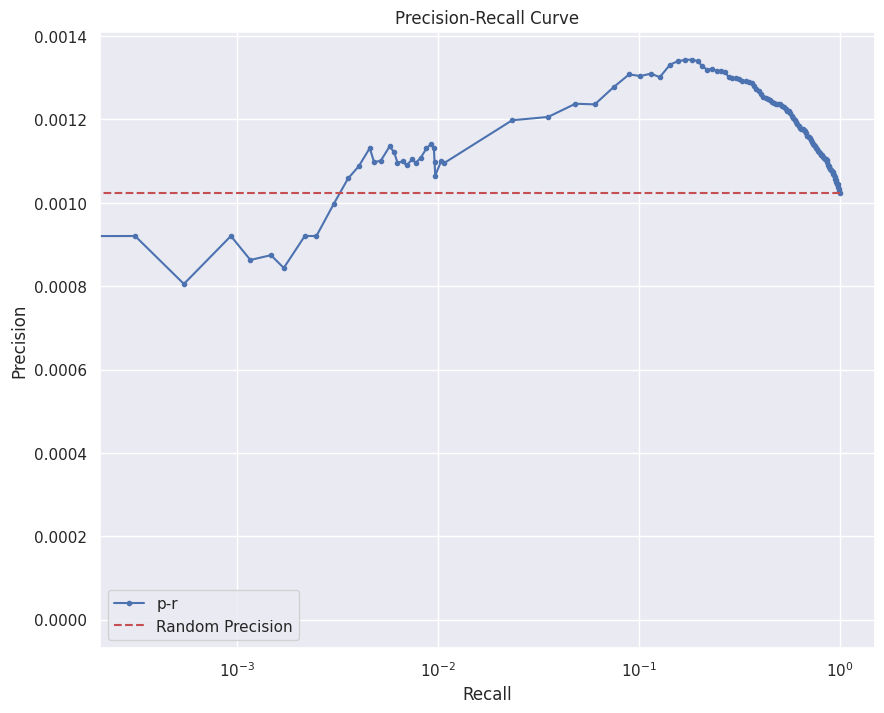

base enrichment


Top central genes: []


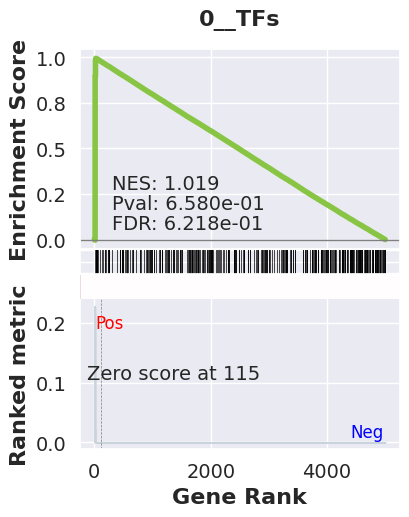

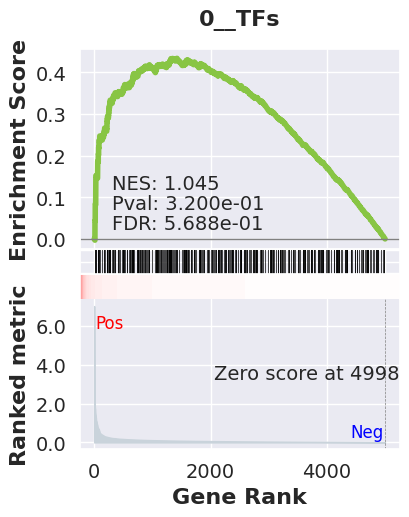

_________________________________________
TF specific enrichment


found some significant results for  11.538461538461538 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3550 genes
intersection pct: 0.7101420284056812
precision:  0.003774679263092466 
recall:  0.3165517775540237 
random precision: 0.0010247679370106238


  0%|                                                                              | 0/128 [00:00<?, ?it/s]

  4%|██▋                                                                   | 5/128 [00:00<00:02, 43.45it/s]

  9%|█████▉                                                               | 11/128 [00:00<00:02, 49.59it/s]

 12%|████████▋                                                            | 16/128 [00:00<00:02, 47.38it/s]

 17%|███████████▊                                                         | 22/128 [00:00<00:02, 48.63it/s]

 21%|██████████████▌                                                      | 27/128 [00:00<00:02, 47.91it/s]

 26%|█████████████████▊                                                   | 33/128 [00:00<00:01, 50.03it/s]

 30%|█████████████████████                                                | 39/128 [00:00<00:01, 49.67it/s]

 34%|███████████████████████▋                                             | 44/128 [00:00<00:01, 49.50it/s]

 39%|██████████████████████████▉                                          | 50/128 [00:01<00:01, 50.20it/s]

 44%|██████████████████████████████▏                                      | 56/128 [00:01<00:01, 49.06it/s]

 48%|█████████████████████████████████▍                                   | 62/128 [00:01<00:01, 50.16it/s]

 53%|████████████████████████████████████▋                                | 68/128 [00:01<00:01, 49.00it/s]

 57%|███████████████████████████████████████▎                             | 73/128 [00:01<00:01, 48.34it/s]

 61%|██████████████████████████████████████████                           | 78/128 [00:01<00:01, 47.51it/s]

 66%|█████████████████████████████████████████████▎                       | 84/128 [00:01<00:00, 48.61it/s]

 70%|███████████████████████████████████████████████▉                     | 89/128 [00:01<00:00, 47.38it/s]

 74%|███████████████████████████████████████████████████▏                 | 95/128 [00:01<00:00, 49.25it/s]

 78%|█████████████████████████████████████████████████████▏              | 100/128 [00:02<00:00, 48.73it/s]

 82%|███████████████████████████████████████████████████████▊            | 105/128 [00:02<00:00, 49.07it/s]

 87%|██████████████████████████████████████████████████████████▉         | 111/128 [00:02<00:00, 50.01it/s]

 91%|█████████████████████████████████████████████████████████████▋      | 116/128 [00:02<00:00, 48.84it/s]

 95%|████████████████████████████████████████████████████████████████▎   | 121/128 [00:02<00:00, 48.94it/s]

 98%|██████████████████████████████████████████████████████████████████▉ | 126/128 [00:02<00:00, 48.66it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:857: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|████████████████████████████████████████████████████████████████████| 128/128 [00:02<00:00, 48.88it/s]

Average Precision (AP):  0.002465189825214692
Area Under Precision-Recall Curve (AUPRC):  0.0020386503812148053
EPR: 4.798605048403869


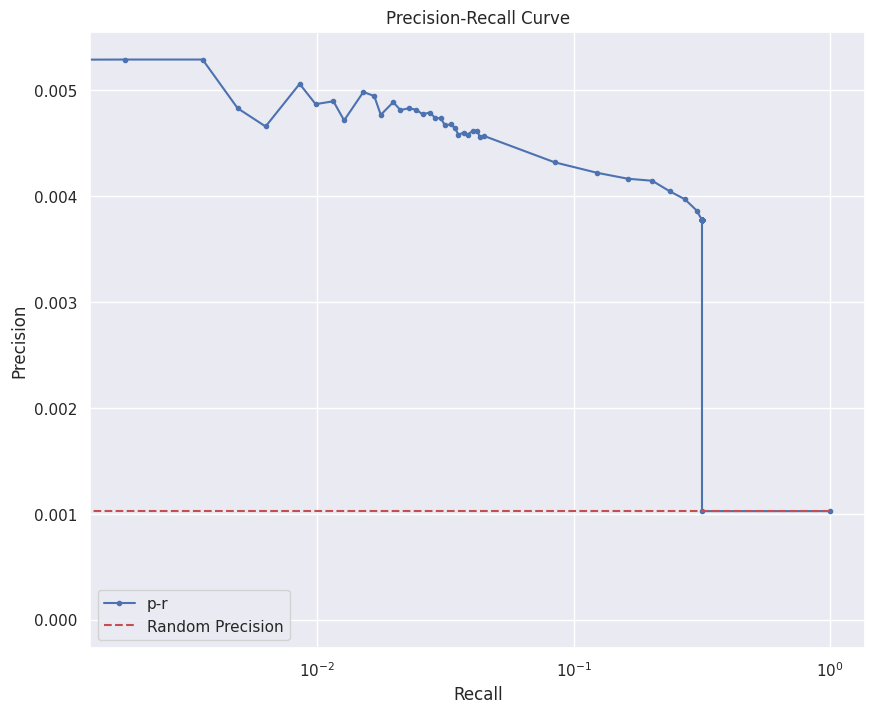

/tmp/ipykernel_2398049/468805686.py:16: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['ensembl_id'] = adata.var.index


Tokenizing /tmp/geneformer/test.h5ad


/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:473: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for i in adata.var["ensembl_id_collapsed"][coding_miRNA_loc]
/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:476: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coding_miRNA_ids = adata.var["ensembl_id_collapsed"][coding_miRNA_loc]


/tmp/geneformer/test.h5ad has no column attribute 'filter_pass'; tokenizing all cells.


Creating dataset.


/home/ml4ig1/miniconda3/envs/geneformer/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
[d3graph] WARNING> CLS token present in token dictionary, excluding from average.


[d3graph] WARNING> EOS token present in token dictionary, excluding from average.


  0%|          | 0/123 [00:00<?, ?it/s]

base enrichment


Top central genes: []


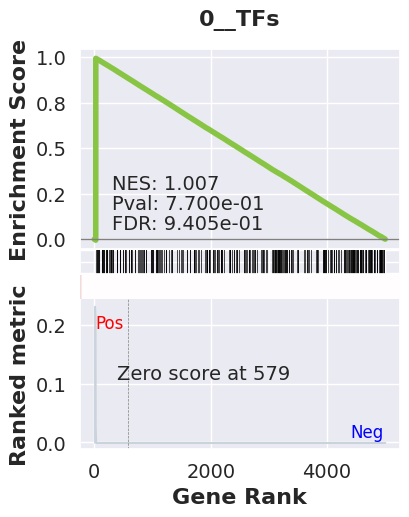

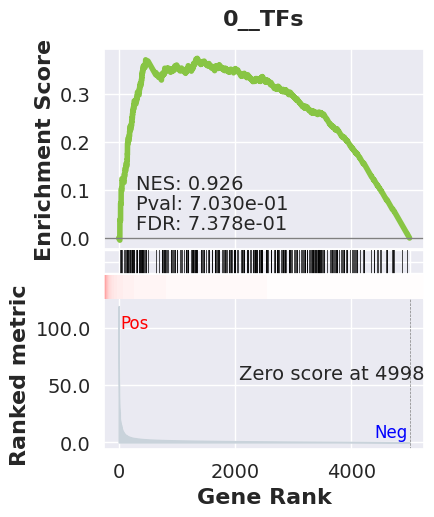

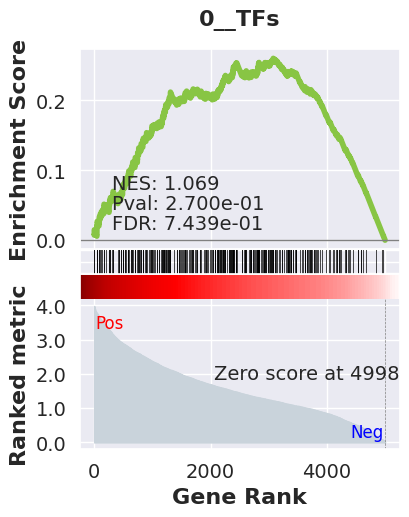

_________________________________________
TF specific enrichment


found some significant results for  12.5 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3675 genes
intersection pct: 0.7351470294058812
precision:  0.0009562070731138268 
recall:  0.9961935834692768 
random precision: 0.0009534178396453846


  0%|                                                                              | 0/128 [00:00<?, ?it/s]

  4%|██▋                                                                   | 5/128 [00:00<00:02, 48.89it/s]

  8%|█████▍                                                               | 10/128 [00:00<00:02, 44.42it/s]

 12%|████████▋                                                            | 16/128 [00:00<00:02, 47.15it/s]

 16%|███████████▎                                                         | 21/128 [00:00<00:02, 45.37it/s]

 20%|██████████████                                                       | 26/128 [00:00<00:02, 46.56it/s]

 24%|████████████████▋                                                    | 31/128 [00:00<00:02, 46.38it/s]

 28%|███████████████████▍                                                 | 36/128 [00:00<00:01, 46.19it/s]

 32%|██████████████████████                                               | 41/128 [00:00<00:01, 45.11it/s]

 36%|████████████████████████▊                                            | 46/128 [00:01<00:01, 45.88it/s]

 40%|███████████████████████████▍                                         | 51/128 [00:01<00:01, 47.01it/s]

 44%|██████████████████████████████▏                                      | 56/128 [00:01<00:01, 45.23it/s]

 48%|████████████████████████████████▉                                    | 61/128 [00:01<00:01, 46.50it/s]

 52%|███████████████████████████████████▌                                 | 66/128 [00:01<00:01, 45.92it/s]

 55%|██████████████████████████████████████▎                              | 71/128 [00:01<00:01, 45.68it/s]

 59%|████████████████████████████████████████▉                            | 76/128 [00:01<00:01, 45.93it/s]

 63%|███████████████████████████████████████████▋                         | 81/128 [00:01<00:01, 45.14it/s]

 67%|██████████████████████████████████████████████▎                      | 86/128 [00:01<00:00, 43.58it/s]

 71%|█████████████████████████████████████████████████                    | 91/128 [00:01<00:00, 44.42it/s]

 75%|███████████████████████████████████████████████████▊                 | 96/128 [00:02<00:00, 45.19it/s]

 79%|█████████████████████████████████████████████████████▋              | 101/128 [00:02<00:00, 44.28it/s]

 84%|████████████████████████████████████████████████████████▊           | 107/128 [00:02<00:00, 45.73it/s]

 88%|███████████████████████████████████████████████████████████▌        | 112/128 [00:02<00:00, 44.32it/s]

 91%|██████████████████████████████████████████████████████████████▏     | 117/128 [00:02<00:00, 45.46it/s]

 95%|████████████████████████████████████████████████████████████████▊   | 122/128 [00:02<00:00, 44.92it/s]

 99%|███████████████████████████████████████████████████████████████████▍| 127/128 [00:02<00:00, 44.96it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:857: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|████████████████████████████████████████████████████████████████████| 128/128 [00:02<00:00, 45.43it/s]

Average Precision (AP):  0.001016104677380659
Area Under Precision-Recall Curve (AUPRC):  0.0010151939943606886
EPR: 1.1409895604446079


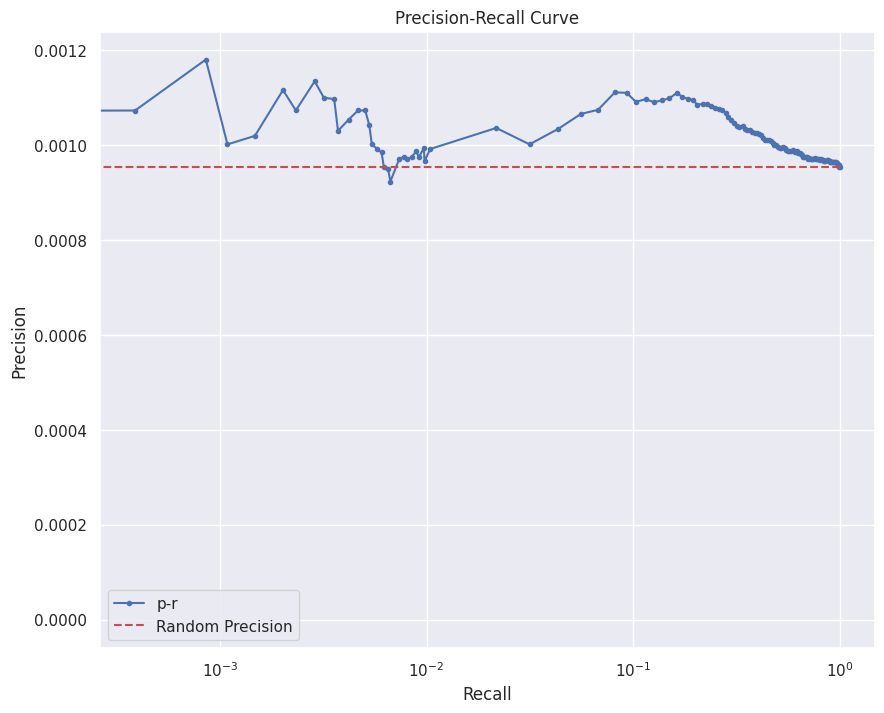

base enrichment


Top central genes: []


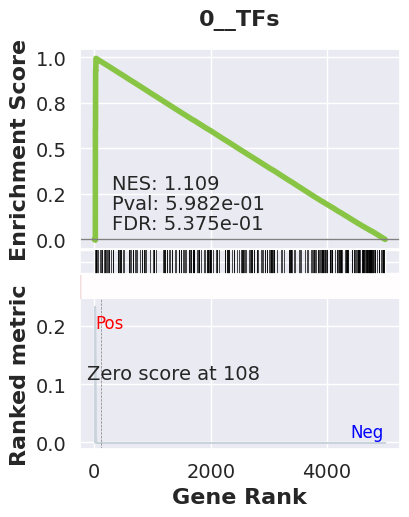

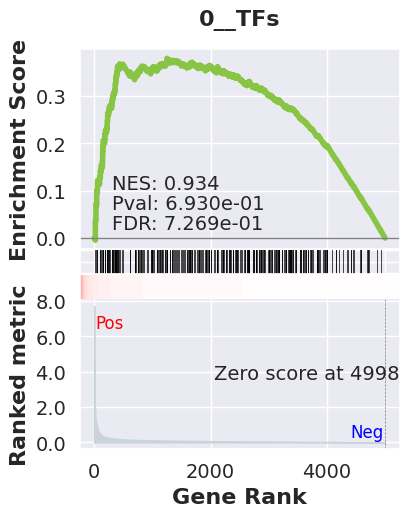

_________________________________________
TF specific enrichment


found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3675 genes
intersection pct: 0.7351470294058812
precision:  0.003125864044965164 
recall:  0.23009399518371787 
random precision: 0.0009534178396453846


  0%|                                                                              | 0/128 [00:00<?, ?it/s]

  4%|██▋                                                                   | 5/128 [00:00<00:02, 47.62it/s]

  8%|█████▍                                                               | 10/128 [00:00<00:02, 43.21it/s]

 12%|████████                                                             | 15/128 [00:00<00:02, 45.21it/s]

 16%|██████████▊                                                          | 20/128 [00:00<00:02, 42.16it/s]

 20%|█████████████▍                                                       | 25/128 [00:00<00:02, 41.85it/s]

 23%|████████████████▏                                                    | 30/128 [00:00<00:02, 42.47it/s]

 27%|██████████████████▊                                                  | 35/128 [00:00<00:02, 44.55it/s]

 31%|█████████████████████▌                                               | 40/128 [00:00<00:01, 44.73it/s]

 35%|████████████████████████▎                                            | 45/128 [00:01<00:01, 44.94it/s]

 39%|██████████████████████████▉                                          | 50/128 [00:01<00:01, 46.31it/s]

 43%|█████████████████████████████▋                                       | 55/128 [00:01<00:01, 44.40it/s]

 47%|████████████████████████████████▎                                    | 60/128 [00:01<00:01, 45.70it/s]

 51%|███████████████████████████████████                                  | 65/128 [00:01<00:01, 44.69it/s]

 55%|█████████████████████████████████████▋                               | 70/128 [00:01<00:01, 45.58it/s]

 59%|████████████████████████████████████████▍                            | 75/128 [00:01<00:01, 46.77it/s]

 63%|███████████████████████████████████████████▋                         | 81/128 [00:01<00:00, 47.86it/s]

 67%|██████████████████████████████████████████████▎                      | 86/128 [00:01<00:00, 46.30it/s]

 72%|█████████████████████████████████████████████████▌                   | 92/128 [00:02<00:00, 47.55it/s]

 76%|████████████████████████████████████████████████████▎                | 97/128 [00:02<00:00, 47.52it/s]

 80%|██████████████████████████████████████████████████████▏             | 102/128 [00:02<00:00, 46.16it/s]

 84%|████████████████████████████████████████████████████████▊           | 107/128 [00:02<00:00, 46.67it/s]

 88%|███████████████████████████████████████████████████████████▌        | 112/128 [00:02<00:00, 44.69it/s]

 91%|██████████████████████████████████████████████████████████████▏     | 117/128 [00:02<00:00, 43.54it/s]

 95%|████████████████████████████████████████████████████████████████▊   | 122/128 [00:02<00:00, 44.78it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:857: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|████████████████████████████████████████████████████████████████████| 128/128 [00:02<00:00, 46.24it/s]

100%|████████████████████████████████████████████████████████████████████| 128/128 [00:02<00:00, 45.35it/s]

Average Precision (AP):  0.001875588359425313
Area Under Precision-Recall Curve (AUPRC):  0.0015283337366714662
EPR: 4.42848095813195


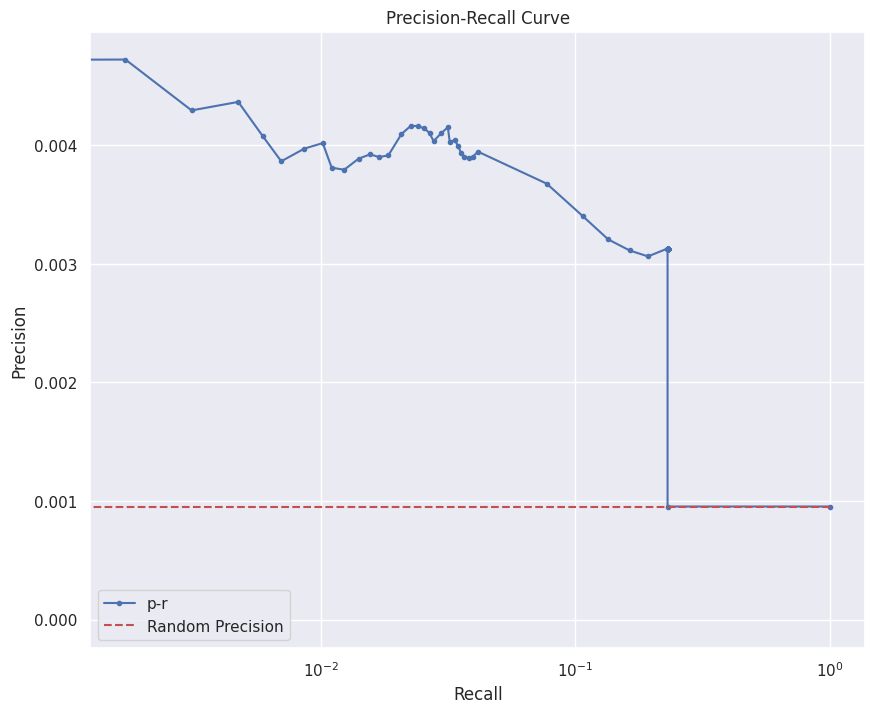

/tmp/ipykernel_2398049/468805686.py:16: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['ensembl_id'] = adata.var.index


Tokenizing /tmp/geneformer/test.h5ad


/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:473: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for i in adata.var["ensembl_id_collapsed"][coding_miRNA_loc]
/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:476: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coding_miRNA_ids = adata.var["ensembl_id_collapsed"][coding_miRNA_loc]


/tmp/geneformer/test.h5ad has no column attribute 'filter_pass'; tokenizing all cells.
Creating dataset.


/home/ml4ig1/miniconda3/envs/geneformer/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
[d3graph] WARNING> CLS token present in token dictionary, excluding from average.


[d3graph] WARNING> EOS token present in token dictionary, excluding from average.


  0%|          | 0/58 [00:00<?, ?it/s]

base enrichment


Top central genes: []


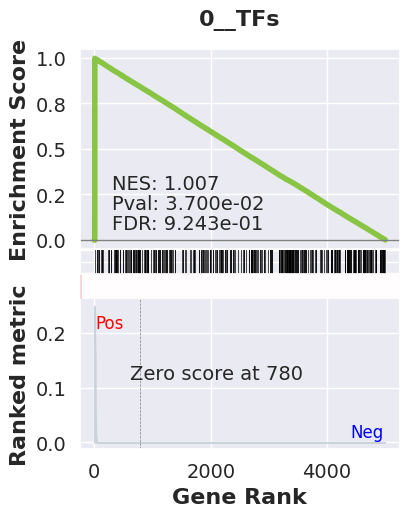

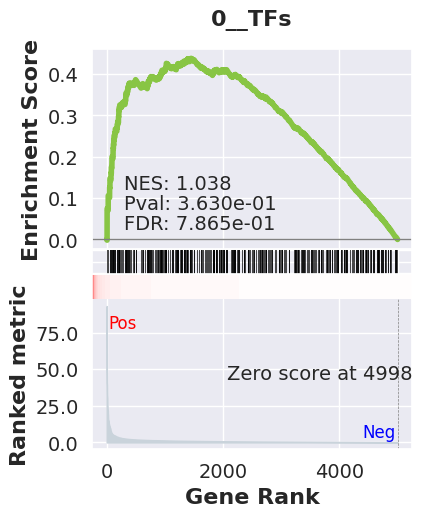

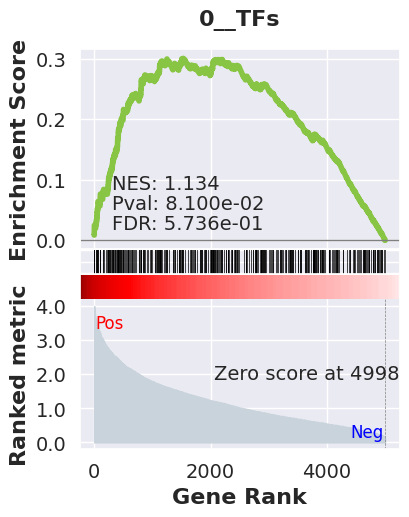

_________________________________________
TF specific enrichment


found some significant results for  24.0 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3645 genes
intersection pct: 0.7291458291658331
precision:  0.001435083681164154 
recall:  0.9965825446898002 
random precision: 0.0014319722820759532


  0%|                                                                              | 0/128 [00:00<?, ?it/s]

  4%|██▋                                                                   | 5/128 [00:00<00:02, 42.61it/s]

  9%|█████▉                                                               | 11/128 [00:00<00:02, 47.56it/s]

 12%|████████▋                                                            | 16/128 [00:00<00:02, 45.77it/s]

 16%|███████████▎                                                         | 21/128 [00:00<00:02, 46.83it/s]

 20%|██████████████                                                       | 26/128 [00:00<00:02, 46.81it/s]

 24%|████████████████▋                                                    | 31/128 [00:00<00:02, 45.72it/s]

 28%|███████████████████▍                                                 | 36/128 [00:00<00:02, 45.80it/s]

 33%|██████████████████████▋                                              | 42/128 [00:00<00:01, 47.43it/s]

 37%|█████████████████████████▎                                           | 47/128 [00:01<00:01, 47.88it/s]

 41%|████████████████████████████                                         | 52/128 [00:01<00:01, 46.85it/s]

 45%|███████████████████████████████▎                                     | 58/128 [00:01<00:01, 48.30it/s]

 49%|█████████████████████████████████▉                                   | 63/128 [00:01<00:01, 46.57it/s]

 54%|█████████████████████████████████████▏                               | 69/128 [00:01<00:01, 48.01it/s]

 58%|███████████████████████████████████████▉                             | 74/128 [00:01<00:01, 47.14it/s]

 62%|███████████████████████████████████████████▏                         | 80/128 [00:01<00:00, 48.23it/s]

 66%|█████████████████████████████████████████████▊                       | 85/128 [00:01<00:00, 47.82it/s]

 70%|████████████████████████████████████████████████▌                    | 90/128 [00:01<00:00, 46.25it/s]

 74%|███████████████████████████████████████████████████▏                 | 95/128 [00:02<00:00, 47.17it/s]

 78%|█████████████████████████████████████████████████████▏              | 100/128 [00:02<00:00, 45.68it/s]

 82%|███████████████████████████████████████████████████████▊            | 105/128 [00:02<00:00, 46.58it/s]

 86%|██████████████████████████████████████████████████████████▍         | 110/128 [00:02<00:00, 46.95it/s]

 90%|█████████████████████████████████████████████████████████████       | 115/128 [00:02<00:00, 46.27it/s]

 95%|████████████████████████████████████████████████████████████████▎   | 121/128 [00:02<00:00, 47.06it/s]

 98%|██████████████████████████████████████████████████████████████████▉ | 126/128 [00:02<00:00, 46.30it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:857: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|████████████████████████████████████████████████████████████████████| 128/128 [00:02<00:00, 46.78it/s]

Average Precision (AP):  0.0018144856391538531
Area Under Precision-Recall Curve (AUPRC):  0.0018142416181959576
EPR: 1.6183598559927654


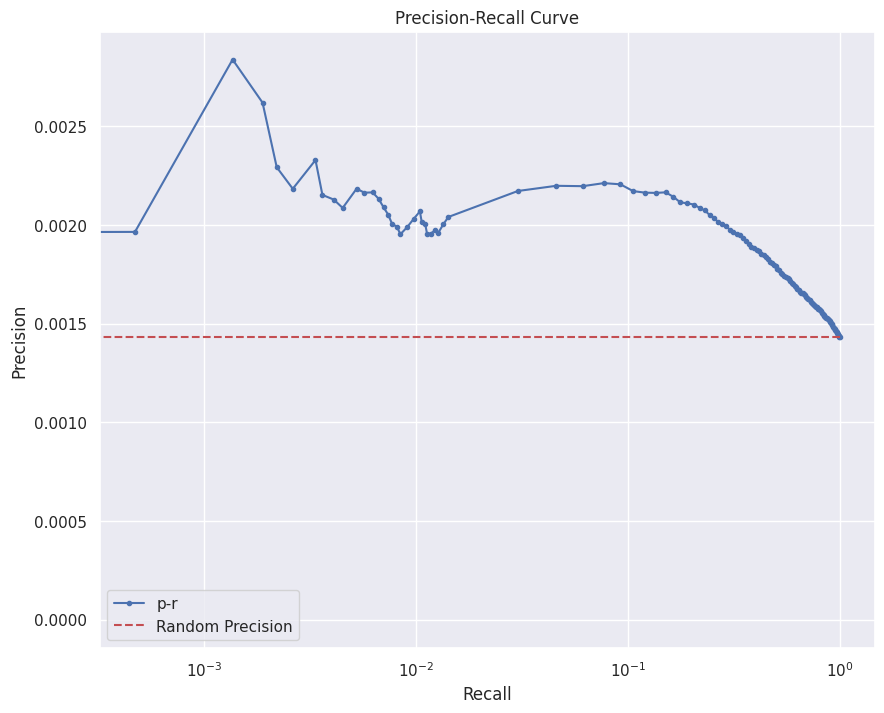

base enrichment


Top central genes: []


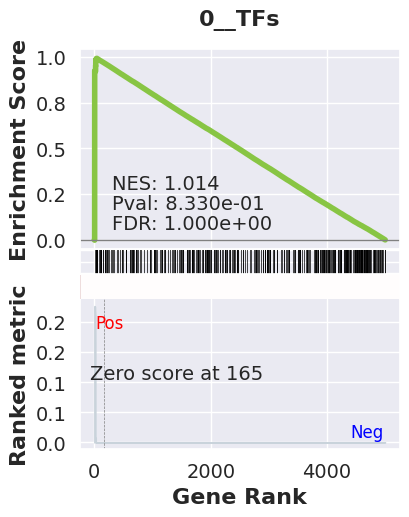

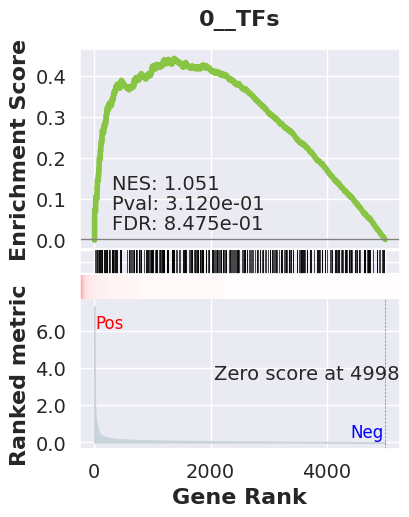

_________________________________________
TF specific enrichment


found some significant results for  4.0 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3645 genes
intersection pct: 0.7291458291658331
precision:  0.006665903123461518 
recall:  0.4100420609884332 
random precision: 0.0014319722820759532


  0%|                                                                              | 0/128 [00:00<?, ?it/s]

  4%|██▋                                                                   | 5/128 [00:00<00:02, 42.01it/s]

  8%|█████▍                                                               | 10/128 [00:00<00:02, 46.26it/s]

 12%|████████                                                             | 15/128 [00:00<00:02, 45.57it/s]

 16%|██████████▊                                                          | 20/128 [00:00<00:02, 44.90it/s]

 20%|█████████████▍                                                       | 25/128 [00:00<00:02, 45.43it/s]

 23%|████████████████▏                                                    | 30/128 [00:00<00:02, 44.71it/s]

 27%|██████████████████▊                                                  | 35/128 [00:00<00:02, 44.15it/s]

 31%|█████████████████████▌                                               | 40/128 [00:00<00:01, 44.61it/s]

 35%|████████████████████████▎                                            | 45/128 [00:00<00:01, 46.11it/s]

 39%|██████████████████████████▉                                          | 50/128 [00:01<00:01, 44.73it/s]

 43%|█████████████████████████████▋                                       | 55/128 [00:01<00:01, 45.47it/s]

 47%|████████████████████████████████▎                                    | 60/128 [00:01<00:01, 44.81it/s]

 51%|███████████████████████████████████                                  | 65/128 [00:01<00:01, 44.73it/s]

 55%|█████████████████████████████████████▋                               | 70/128 [00:01<00:01, 44.27it/s]

 59%|████████████████████████████████████████▍                            | 75/128 [00:01<00:01, 43.75it/s]

 62%|███████████████████████████████████████████▏                         | 80/128 [00:01<00:01, 41.91it/s]

 66%|█████████████████████████████████████████████▊                       | 85/128 [00:01<00:01, 42.90it/s]

 70%|████████████████████████████████████████████████▌                    | 90/128 [00:02<00:00, 44.57it/s]

 74%|███████████████████████████████████████████████████▏                 | 95/128 [00:02<00:00, 43.50it/s]

 78%|█████████████████████████████████████████████████████▏              | 100/128 [00:02<00:00, 45.00it/s]

 82%|███████████████████████████████████████████████████████▊            | 105/128 [00:02<00:00, 44.50it/s]

 86%|██████████████████████████████████████████████████████████▍         | 110/128 [00:02<00:00, 44.99it/s]

 90%|█████████████████████████████████████████████████████████████       | 115/128 [00:02<00:00, 44.10it/s]

 94%|███████████████████████████████████████████████████████████████▊    | 120/128 [00:02<00:00, 44.10it/s]

 98%|██████████████████████████████████████████████████████████████████▍ | 125/128 [00:02<00:00, 43.10it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:857: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|████████████████████████████████████████████████████████████████████| 128/128 [00:02<00:00, 44.36it/s]

Average Precision (AP):  0.004641395138676367
Area Under Precision-Recall Curve (AUPRC):  0.004040971324247982
EPR: 6.678536787201536


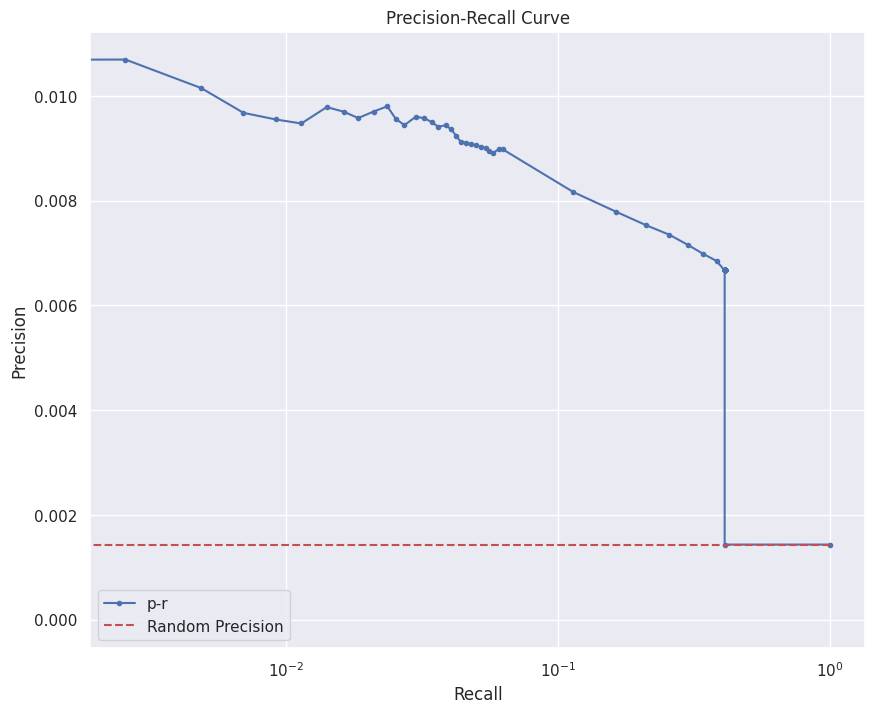

/tmp/ipykernel_2398049/468805686.py:16: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['ensembl_id'] = adata.var.index


Tokenizing /tmp/geneformer/test.h5ad


/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:473: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for i in adata.var["ensembl_id_collapsed"][coding_miRNA_loc]
/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:476: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coding_miRNA_ids = adata.var["ensembl_id_collapsed"][coding_miRNA_loc]


/tmp/geneformer/test.h5ad has no column attribute 'filter_pass'; tokenizing all cells.
Creating dataset.


/home/ml4ig1/miniconda3/envs/geneformer/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
[d3graph] WARNING> CLS token present in token dictionary, excluding from average.


[d3graph] WARNING> EOS token present in token dictionary, excluding from average.


  0%|          | 0/58 [00:00<?, ?it/s]

base enrichment


Top central genes: []


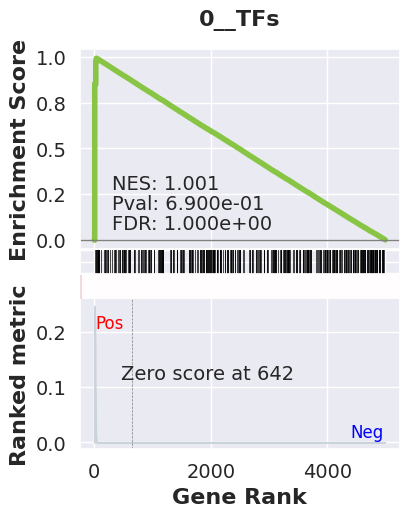

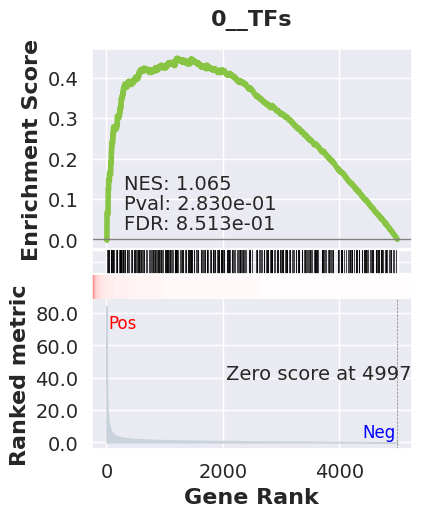

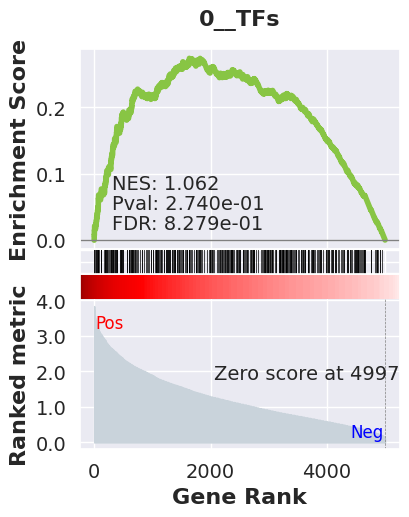

_________________________________________
TF specific enrichment


found some significant results for  30.303030303030305 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3763 genes
intersection pct: 0.7529011604641856
precision:  0.0018310998919482578 
recall:  0.9926773808147378 
random precision: 0.0018328804641517063


  0%|                                                                              | 0/128 [00:00<?, ?it/s]

  3%|██▏                                                                   | 4/128 [00:00<00:03, 36.59it/s]

  6%|████▍                                                                 | 8/128 [00:00<00:03, 35.68it/s]

  9%|██████▍                                                              | 12/128 [00:00<00:03, 37.39it/s]

 13%|█████████▏                                                           | 17/128 [00:00<00:02, 39.22it/s]

 16%|███████████▎                                                         | 21/128 [00:00<00:02, 38.71it/s]

 20%|██████████████                                                       | 26/128 [00:00<00:02, 40.52it/s]

 24%|████████████████▋                                                    | 31/128 [00:00<00:02, 40.21it/s]

 28%|███████████████████▍                                                 | 36/128 [00:00<00:02, 41.47it/s]

 32%|██████████████████████                                               | 41/128 [00:01<00:02, 41.98it/s]

 36%|████████████████████████▊                                            | 46/128 [00:01<00:01, 41.55it/s]

 40%|███████████████████████████▍                                         | 51/128 [00:01<00:01, 40.37it/s]

 44%|██████████████████████████████▏                                      | 56/128 [00:01<00:01, 41.21it/s]

 48%|████████████████████████████████▉                                    | 61/128 [00:01<00:01, 40.89it/s]

 52%|███████████████████████████████████▌                                 | 66/128 [00:01<00:01, 41.06it/s]

 55%|██████████████████████████████████████▎                              | 71/128 [00:01<00:01, 41.85it/s]

 59%|████████████████████████████████████████▉                            | 76/128 [00:01<00:01, 41.57it/s]

 63%|███████████████████████████████████████████▋                         | 81/128 [00:01<00:01, 42.60it/s]

 67%|██████████████████████████████████████████████▎                      | 86/128 [00:02<00:01, 41.96it/s]

 71%|█████████████████████████████████████████████████                    | 91/128 [00:02<00:00, 41.14it/s]

 75%|███████████████████████████████████████████████████▊                 | 96/128 [00:02<00:00, 42.21it/s]

 79%|█████████████████████████████████████████████████████▋              | 101/128 [00:02<00:00, 43.43it/s]

 83%|████████████████████████████████████████████████████████▎           | 106/128 [00:02<00:00, 41.84it/s]

 87%|██████████████████████████████████████████████████████████▉         | 111/128 [00:02<00:00, 43.14it/s]

 91%|█████████████████████████████████████████████████████████████▋      | 116/128 [00:02<00:00, 41.97it/s]

 95%|████████████████████████████████████████████████████████████████▎   | 121/128 [00:02<00:00, 43.18it/s]

 98%|██████████████████████████████████████████████████████████████████▉ | 126/128 [00:03<00:00, 42.34it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:857: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|████████████████████████████████████████████████████████████████████| 128/128 [00:03<00:00, 41.36it/s]

Average Precision (AP):  0.0021008135893807326
Area Under Precision-Recall Curve (AUPRC):  0.0021003525819565066
EPR: 1.2628382132543454


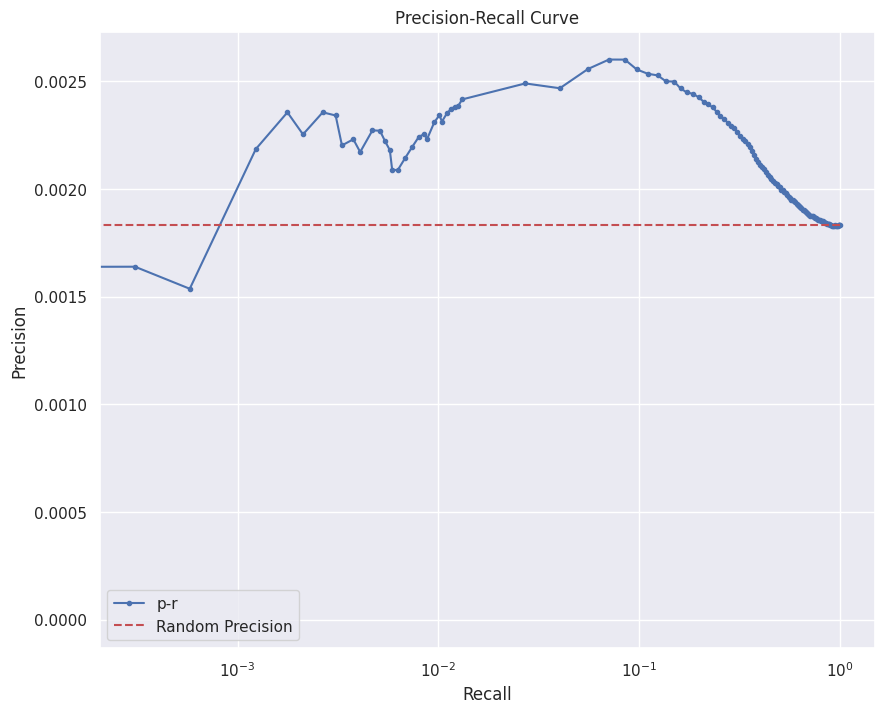

base enrichment


Top central genes: []


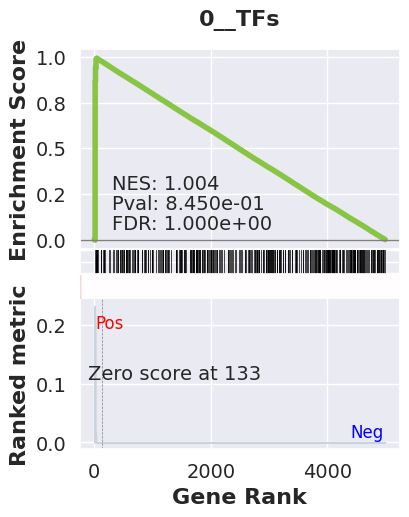

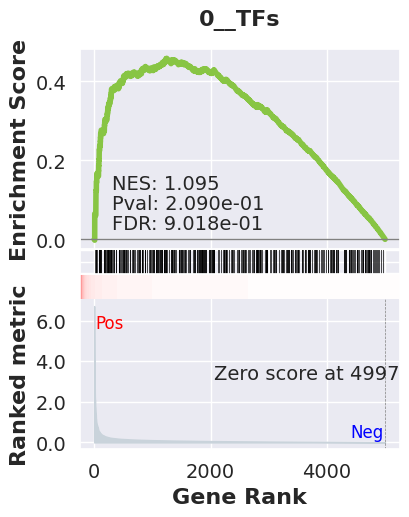

_________________________________________
TF specific enrichment


found some significant results for  4.545454545454546 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3763 genes
intersection pct: 0.7529011604641856
precision:  0.009152148300656408 
recall:  0.4505723204994797 
random precision: 0.0018328804641517063


  0%|                                                                              | 0/128 [00:00<?, ?it/s]

  4%|██▋                                                                   | 5/128 [00:00<00:02, 45.32it/s]

  8%|█████▍                                                               | 10/128 [00:00<00:02, 42.13it/s]

 12%|████████                                                             | 15/128 [00:00<00:02, 43.47it/s]

 16%|██████████▊                                                          | 20/128 [00:00<00:02, 43.15it/s]

 20%|█████████████▍                                                       | 25/128 [00:00<00:02, 42.83it/s]

 23%|████████████████▏                                                    | 30/128 [00:00<00:02, 40.54it/s]

 27%|██████████████████▊                                                  | 35/128 [00:00<00:02, 41.40it/s]

 31%|█████████████████████▌                                               | 40/128 [00:00<00:02, 41.56it/s]

 35%|████████████████████████▎                                            | 45/128 [00:01<00:01, 41.62it/s]

 39%|██████████████████████████▉                                          | 50/128 [00:01<00:01, 42.59it/s]

 43%|█████████████████████████████▋                                       | 55/128 [00:01<00:01, 41.71it/s]

 47%|████████████████████████████████▎                                    | 60/128 [00:01<00:01, 42.62it/s]

 51%|███████████████████████████████████                                  | 65/128 [00:01<00:01, 41.73it/s]

 55%|█████████████████████████████████████▋                               | 70/128 [00:01<00:01, 40.92it/s]

 59%|████████████████████████████████████████▍                            | 75/128 [00:01<00:01, 41.70it/s]

 62%|███████████████████████████████████████████▏                         | 80/128 [00:01<00:01, 43.18it/s]

 66%|█████████████████████████████████████████████▊                       | 85/128 [00:02<00:01, 41.87it/s]

 70%|████████████████████████████████████████████████▌                    | 90/128 [00:02<00:00, 42.78it/s]

 74%|███████████████████████████████████████████████████▏                 | 95/128 [00:02<00:00, 41.81it/s]

 78%|█████████████████████████████████████████████████████▏              | 100/128 [00:02<00:00, 42.22it/s]

 82%|███████████████████████████████████████████████████████▊            | 105/128 [00:02<00:00, 40.92it/s]

 86%|██████████████████████████████████████████████████████████▍         | 110/128 [00:02<00:00, 40.98it/s]

 90%|█████████████████████████████████████████████████████████████       | 115/128 [00:02<00:00, 41.20it/s]

 94%|███████████████████████████████████████████████████████████████▊    | 120/128 [00:02<00:00, 42.43it/s]

 98%|██████████████████████████████████████████████████████████████████▍ | 125/128 [00:02<00:00, 41.09it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:857: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|████████████████████████████████████████████████████████████████████| 128/128 [00:03<00:00, 41.87it/s]

Average Precision (AP):  0.00597844463674513
Area Under Precision-Recall Curve (AUPRC):  0.005203842139439212
EPR: 6.828599689222875


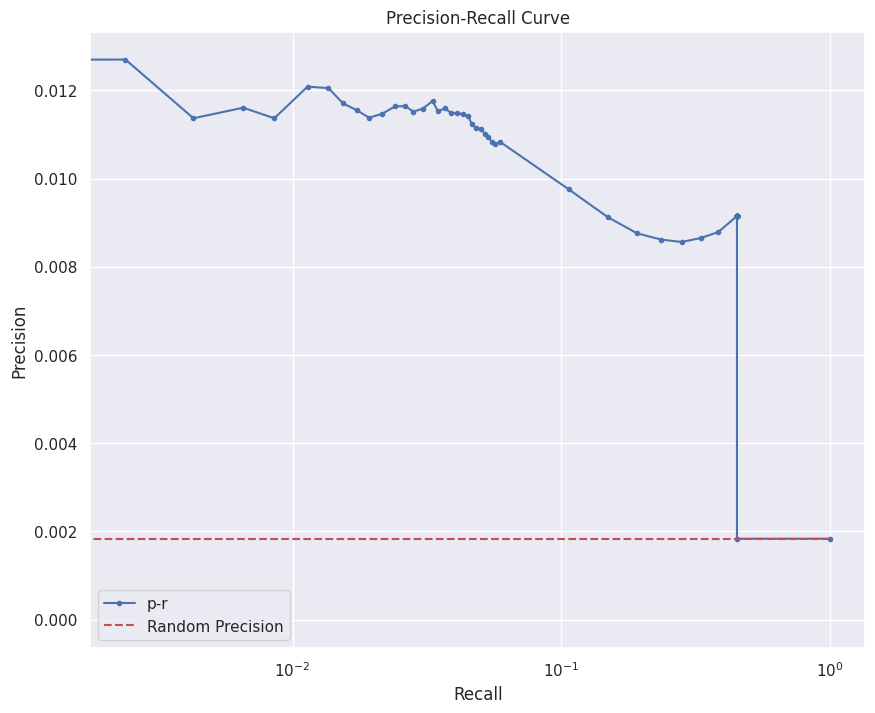

In [6]:
sc.tl.rank_genes_groups(
    adata, groupby="cell_type"
)
adata.var['ensembl_id'] = adata.var.index
adata = adata[adata.X.sum(1) > 500]
metrics = {}
shapes = []
for celltype in CELLTYPES:
    to_use = adata.uns["rank_genes_groups"]["names"][celltype][
        : NUM_GENES
    ].tolist()
    subadata = adata[adata.obs.cell_type == celltype][:MAXCELLS, adata.var.index.isin(to_use)]
    grn = compute_geneformer_network(
        subadata)
    grn.var.index = make_index_unique(
        grn.var['symbol'].astype(str))
    metrics['geneformer_'+celltype] = BenGRN(grn,
                                            do_auc=True, doplot=True).scprint_benchmark()
    grn.varp['GRN'][~grn.var.isTF, :] = 0
    grn.var.index = make_index_unique(
        grn.var['symbol'].astype(str))
    metrics['geneformer_TF_'+celltype] = BenGRN(grn,
                                         do_auc=True, doplot=True).scprint_benchmark()
    shapes.append(grn.shape[1])

In [7]:
metrics

{'geneformer_retinal rod cell': {'TF_enr': False,
  'significant_enriched_TFtargets': 0.0,
  'precision': 0.0007555156889765451,
  'recall': 0.3545816733067729,
  'rand_precision': 0.0006670174487512689,
  'auprc': 0.0008124073085834153,
  'ap': 0.0009054023493249836,
  'epr': 0.0},
 'geneformer_TF_retinal rod cell': {'TF_enr': False,
  'significant_enriched_TFtargets': 66.66666666666667,
  'precision': 0.005376763032806047,
  'recall': 0.18326693227091634,
  'rand_precision': 0.0006670174487512689,
  'auprc': 0.0019526636510102642,
  'ap': 0.0024262226423799036,
  'epr': 12.122449637909066},
 'geneformer_Mueller cell': {'TF_enr': False,
  'enriched_terms_Regulators': ['celltype.gmt__Microglial cells'],
  'enriched_terms_Targets': ['celltype.gmt__Muller cells',
   'celltype.gmt__Adipocytes'],
  'significant_enriched_TFtargets': 17.24137931034483,
  'precision': 0.0013727051961657907,
  'recall': 0.9936172554198305,
  'rand_precision': 0.001376576029580251,
  'auprc': 0.0016706031836856

In [8]:
shapes

[2617, 4999, 4999, 5000, 4999, 4998, 4999, 4999, 4999, 4998]

In [9]:
True
True
True
True
True
True
True
True
False
True
False
True
False
False
False
True
False
True
True
False

False

In [10]:
res = []
for k, v in metrics.items():
    res.append([k.split('_')[-1], v['epr'], v['auprc'], v['rand_precision'], v['significant_enriched_TFtargets'], v.get('TF_enr', False), 'tf_' in k])

df = pd.DataFrame(res, columns=['name','EPR', 'AUPRC', 'RAND', 'TF_targ', 'TF_enr', 'TF_only'])
df

name        EPR     AUPRC      RAND    TF_targ  TF_enr  \
0         retinal rod cell   0.000000  0.000812  0.000667   0.000000   False   
1         retinal rod cell  12.122450  0.001953  0.000667  66.666667   False   
2             Mueller cell   1.802683  0.001671  0.001377  17.241379   False   
3             Mueller cell   6.450403  0.003670  0.001377   0.000000   False   
4            amacrine cell   1.378360  0.000943  0.000820  21.428571   False   
5            amacrine cell   4.153861  0.001447  0.000820   0.000000   False   
6          ON-bipolar cell   3.022855  0.000957  0.000768   6.666667   False   
7          ON-bipolar cell   3.174734  0.001136  0.000768   6.666667   False   
8         rod bipolar cell   1.607306  0.000874  0.000672   7.142857   False   
9         rod bipolar cell   4.842844  0.001002  0.000672  17.857143   False   
10       retinal cone cell   2.055039  0.000958  0.000768  15.151515   False   
11       retinal cone cell   8.018572  0.001585  0.000768  18.181818   False   
12  retina horizontal cell   0.906803  0.001208  0.001025  23.076923   False   
13  retina horizontal cell   4.798605  0.002039  0.001025  11.538462   False   
14   retinal ganglion cell   1.140990  0.001015  0.000953  12.500000   False   
15   retinal ganglion cell   4.428481  0.001528  0.000953   0.000000   False   
16               astrocyte   1.618360  0.001814  0.001432  24.000000   False   
17               astrocyte   6.678537  0.004041  0.001432   4.000000   False   
18         microglial cell   1.262838  0.002100  0.001833  30.303030   False   
19         microglial cell   6.828600  0.005204  0.001833   4.545455   False   

    TF_only  
0     False  
1     False  
2     False  
3     False  
4     False  
5     False  
6     False  
7     False  
8     False  
9     False  
10    False  
11    False  
12    False  
13    False  
14    False  
15    False  
16    False  
17    False  
18    False  
19    False